In [1]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import random
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
from wordcloud import WordCloud , ImageColorGenerator
import nltk as nltk
import nltk
nltk.download('wordnet')
import string
from nltk.tokenize import word_tokenize  # For text tokenization
from nltk.corpus import stopwords  # For stopword removal
from sklearn.feature_extraction.text import TfidfVectorizer  # For cosine similarity
from textblob import TextBlob  # For sentiment analysis
from nltk.corpus import stopwords
from textblob import TextBlob
import emoji
#from emoji import UNICODE_EMOJI
import contractions
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer  # Stemming and Lemmatization
from collections import Counter  # For n-gram frequency
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import nltk
nltk.download('punkt')
import nltk
nltk.download('stopwords')
import itertools
import seaborn as sns
import squarify

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\veena\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\veena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\veena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reading in Appliances sample data
appliances_df = pd.read_csv('Applicances_Superset_data.csv')

C:\Users\veena\AppData\Local\Temp\ipykernel_57748\3289130923.py:2: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
# Creating copy for backup
appliances_df_working = appliances_df.copy()

In [5]:
# Data snapshot
appliances_df_working.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN


In [6]:
appliances_df_working.dtypes

overall            int64
vote              object
verified            bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
image             object
dtype: object

In [7]:
# Checking and removing duplicates

# Original dataset count
print("Before deduplication shape:")
print(appliances_df_working.shape)

# Performing deduplication
appliances_df_working_dedup = appliances_df_working.drop_duplicates()

# Print the DataFrame after deduplication
print("\nAfter deduplication shape:")
print(appliances_df_working_dedup.shape)

Before deduplication shape:
(602777, 12)

After deduplication shape:
(591371, 12)


In [8]:
# Calculating percentage of duplicates removed
original_count = appliances_df_working.shape[0]
deduplicated_count = appliances_df_working_dedup.shape[0]
percentage_removed = ((original_count - deduplicated_count) / original_count) * 100

print("\nPercentage of duplicates removed:", percentage_removed, "%")


Percentage of duplicates removed: 1.8922420729390803 %



## After deduplication from overall data, less than 2% of data was duplicate which is negligible considering the amount of data for applicances category

In [9]:
# Function to count missing values (including NA, NaNs, and 0)
def count_missing(df):
    missing_counts = df.isna().sum()  # Count missing values (NaN)
    missing_counts = missing_counts.add(df.eq(0).sum(), axis=0)  # Count zeros
    return missing_counts

# Printing the counts of missing values
missing_value_counts = count_missing(appliances_df_working_dedup.copy())
print(missing_value_counts)

overall                0
vote              529749
verified           37781
reviewTime             0
reviewerID             0
asin                   0
style             455622
reviewerName          80
reviewText           351
summary              138
unixReviewTime         0
image             583097
dtype: int64


### Data overview and treatment required

1) overall = star rating, keep as is
2) verified = is this verified purchase or not? convert blank to false and to be used for getting helpfulness dependent variable
3) reviewTime = this is in mm dd, yyyy format, need to convert to standard format and then subtract from end of 2018 to get review age
4) reviewerID = ID of the reviewer, keep as is
5) asin = Amazon Standard Identification Number, standard product ID number, keep as is
6) style = describes the SKU or variant, attempt to standardize
7) reviewName = name of the reviewer, keep as is
8) reviewText = actual review text; meta data to be extracted from raw data, text cleaning/mining to be performed and then converted to tfidf matrix
9) summary = review title, meta data to be extracted, similarity to reviewText to be calculated
10) vote = number of votes for helpfulness, convert blank to 0 and to be used for getting helpfulness dependent variable
11) image = URL of image if available, to be converted to flag of whether image is available or not

In [10]:
# Data treatment
# reviewTime date standardization

# format string from the original date format
format_string = "%m %d, %Y"  # mm dd, yyyy

# Standardizing date format
appliances_df_working_dedup["reviewTime_cleaned"] = pd.to_datetime(appliances_df_working_dedup["reviewTime"], format=format_string)

# Checking to see if it worked
appliances_df_working_dedup.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewTime_cleaned
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN,2013-11-27
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN,2013-11-01


In [11]:
appliances_df_working_dedup.shape

(591371, 13)

#### Filtering the data for 2010-2018

In [12]:
# Extracting year, month, day from the review datetime
appliances_df_working_dedup["review_year"] = pd.to_datetime(appliances_df_working_dedup["reviewTime_cleaned"]).dt.year
appliances_df_working_dedup["review_month"] = pd.to_datetime(appliances_df_working_dedup["reviewTime_cleaned"]).dt.month
appliances_df_working_dedup["review_day"] = pd.to_datetime(appliances_df_working_dedup["reviewTime_cleaned"]).dt.day

# Filtering out data before 2010
appliances_df_working_dedup_filter = appliances_df_working_dedup[(appliances_df_working_dedup['review_year'] >= 2010) &
                                           (appliances_df_working_dedup['review_year'] <= 2018)]

In [13]:
# Calculating percentage of filtered records after filtering data for 2010-2018
dedup_count = appliances_df_working_dedup.shape[0]
filter_count = appliances_df_working_dedup_filter.shape[0]
percentage_filtered = ((dedup_count-filter_count)  / dedup_count) *100
print("\nPercentage of records removed after filtering:", percentage_filtered, "%")


Percentage of records removed after filtering: 0.6019909667535269 %


#### After filtering the data for 2010-2018, we have excluded 3560 records or 0.60% of data which is negligible

In [14]:
# Data treatment
# Verified imputation
# There are 37781 missing values for which we will impute with False
# If there is missing data then it is false

# Imputing missing values with False in the verified column
appliances_df_working_dedup_filter['verified_clean'] = appliances_df_working_dedup_filter['verified'].fillna(False)

# Checking the imputation
print(appliances_df_working_dedup_filter['verified_clean'].isnull().sum())  # Should be 0 after imputation

0


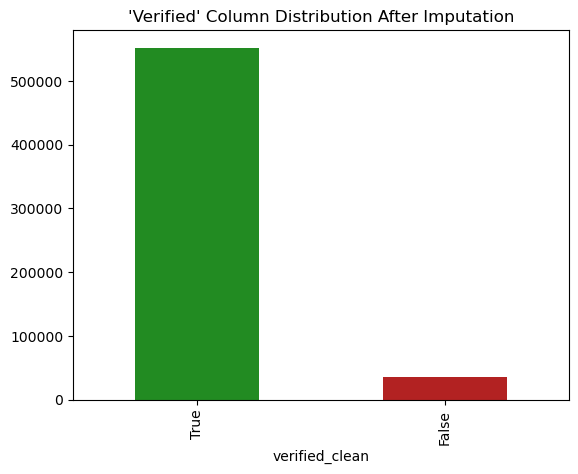

In [15]:
# Plotting the distribution of the 'verified_clean' column after imputation

# Counting the occurrences of each unique value in the 'verified_clean' column
value_counts = appliances_df_working_dedup_filter['verified_clean'].value_counts()

# Defining colors for the bars
colors = ['forestgreen', 'firebrick']

# Creating a bar plot to visualize the distribution
value_counts.plot(kind='bar', color=colors)

# Adding title to the plot
plt.title("'Verified' Column Distribution After Imputation")

# Displaying the plot
plt.show()

In [16]:
# Data treatment
# Vote imputation
# There are 529749 missing values for which we will impute with 0
# 529K. If the votes are missing, then they are zero and hence we are imputing with zero

# Imputing missing values with 0
appliances_df_working_dedup_filter["vote_clean"] = appliances_df_working_dedup_filter["vote"].fillna(0)

# Checking the imputation
print(appliances_df_working_dedup_filter['vote_clean'].isnull().sum())  # Should be 0 after imputation

0


In [17]:
# Data treatment
# reviewName imputation
# There are 80 missing values which will be imputed with "Unknown"
# If the reviewer name is missing, we don't know who the user is and hence, we are imputing the missing values with "Unknown".
appliances_df_working_dedup["reviewerName_clean"] = appliances_df_working_dedup["reviewerName"].fillna("Unknown")

# Checking the imputation
print(appliances_df_working_dedup['reviewerName_clean'].isnull().sum())  # Should be 0 after imputation.

0


In [18]:
# Data treatment
# reviewText imputation
# There are 351 missing values in reviewText and hence, these records will be excluded. We are excluding because it is neglible

appliances_df_working_dedup = appliances_df_working_dedup.dropna(subset=["reviewText"])
# Checking the imputation
print(appliances_df_working_dedup['reviewText'].isnull().sum())  # Should be 0 after imputation.

0


In [19]:
# Data treatment
# summary imputation
# There are 138 missing values in summary which will be excluded because it is neglible
appliances_df_working_dedup = appliances_df_working_dedup.dropna(subset=["summary"])
# Checking the imputation
print(appliances_df_working_dedup['summary'].isnull().sum())  # Should be 0 after imputation.

0


In [20]:
# Data treatment
# Image URL availability

# Defining a regular expression for URL validation
# Observed from the data that non-null values have https pattern
url_regex = r"https?://\S+"

# Creating a new column with flag based on URL presence
appliances_df_working_dedup_filter['image_available'] = appliances_df_working_dedup_filter['image'].apply(lambda x:
                                                                                            bool(re.match(url_regex, str(x))))

# Check
appliances_df_working_dedup_filter.tail()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewTime_cleaned,review_year,review_month,review_day,verified_clean,vote_clean,image_available
602772,5,NaN,True,"08 10, 2017",A24A9P4F2SLTK5,B01HJH2PY0,NaN,Tana,perfect replacement for our broken one.,Five Stars,1502323200,NaN,2017-08-10,2017,8,10,True,0,False
602773,2,NaN,True,"08 1, 2018",A2JCB4KHBWEELW,B01HJHHEA0,NaN,CMA,"Quick delivery, did not fit my stove.",Two Stars,1533081600,NaN,2018-08-01,2018,8,1,True,0,False
602774,5,NaN,True,"04 13, 2018",A1LDYYVTLPP2Z5,B01HJHHEA0,NaN,Himmy,Perfect match for my oven!,Five Stars,1523577600,NaN,2018-04-13,2018,4,13,True,0,False
602775,1,NaN,True,"03 23, 2018",AP1M5O06IOYZ7,B01HJH92JQ,NaN,Alberto,Doesn't work with Bosch SHX33A06UC/14 dishwash...,Doesn't work with Bosch SHX33A06UC/14 dishwash...,1521763200,NaN,2018-03-23,2018,3,23,True,0,False
602776,3,NaN,True,"01 8, 2018",A1BU98NV4Y0P9K,B01HJH92JQ,NaN,RobMckenner,The switch works with my dishwasher after I mo...,The switch works with my dishwasher after I mo...,1515369600,NaN,2018-01-08,2018,1,8,True,0,False


## Creating the dependent variable - helpfulness

In [21]:
appliances_df_working_dedup_filter.dtypes
# vote_clean is a string, needs to be converted to numeric

appliances_df_working_dedup_filter["vote_clean"] = pd.to_numeric(appliances_df_working_dedup_filter["vote_clean"],
                                                                 errors='coerce')

In [22]:
#appliances_df_working_dedup.dtypes
appliances_df_working_dedup_filter.describe()

,overall,unixReviewTime,reviewTime_cleaned,review_year,review_month,review_day,vote_clean
count,587811.000000,5.878110e+05,587811,587811.000000,587811.000000,587811.000000,587807.000000
mean,4.278373,1.457086e+09,2016-03-04 09:58:53.231599872,2015.696283,6.254769,15.698728,0.822309
min,1.000000,1.262304e+09,2010-01-01 00:00:00,2010.000000,1.000000,1.000000,0.000000
25%,4.000000,1.424650e+09,2015-02-23 00:00:00,2015.000000,3.000000,8.000000,0.000000
50%,5.000000,1.464912e+09,2016-06-03 00:00:00,2016.000000,6.000000,16.000000,0.000000
75%,5.000000,1.496621e+09,2017-06-05 00:00:00,2017.000000,9.000000,23.000000,0.000000
max,5.000000,1.538611e+09,2018-10-04 00:00:00,2018.000000,12.000000,31.000000,970.000000
std,1.299453,5.103983e+07,NaN,1.654979,3.478250,8.826655,7.686854


In [23]:
appliances_df_working_dedup_filter.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewTime_cleaned,review_year,review_month,review_day,verified_clean,vote_clean,image_available
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN,2013-11-27,2013,11,27,False,2.0,False
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN,2013-11-01,2013,11,1,False,0.0,False


In [25]:
# Checking for non-numeric values after conversion
non_numeric_count = appliances_df_working_dedup_filter["vote_clean"].isna().sum()
if non_numeric_count > 0:
    print(f"Warning: {non_numeric_count} non-numeric values in vote_clean after conversion")

In [26]:
appliances_df_working_dedup_filter["vote_clean"].unique()

array([  2.,   0.,  10.,   3.,   5.,   4.,  21.,   7.,   8.,  11.,   9.,
        35.,  17.,   6.,  83.,  12.,  18.,  39.,  19.,  23.,  14.,  40.,
        49.,  15., 116.,  13.,  22.,  16.,  67.,  33.,  44.,  20.,  26.,
        42., 295.,  25., 173., 259.,  93.,  41.,  30.,  63.,  24.,  60.,
        71.,  31.,  28.,  58.,  91.,  34., 172., 105.,  32., 180.,  47.,
       111., 152., 163.,  85.,  27., 199., 244., 491., 154., 228., 137.,
        51.,  43., 193.,  36.,  37.,  50., 136.,  65.,  70.,  38.,  29.,
        57.,  46.,  52., 204., 167.,  95.,  84.,  45.,  87., 104., 115.,
       161., 279.,  53.,  90.,  55.,  78., 170., 548.,  77., 326., 970.,
        81., 523.,  68.,  73.,  76.,  99.,  74.,  64., 557.,  62., 203.,
       174., 213., 134., 127.,  69.,  48., 125., 309., 165., 219.,  nan,
       122., 168., 101., 100., 222., 184., 182., 103.,  89., 139., 285.,
       129.,  80., 117.,  59., 646., 346.,  61.,  72., 311.,  66., 372.,
       802., 112., 181., 108., 432., 542., 442., 15

In [27]:
print(appliances_df_working_dedup_filter.columns)

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image', 'reviewTime_cleaned', 'review_year', 'review_month',
       'review_day', 'verified_clean', 'vote_clean', 'image_available'],
      dtype='object')


In [28]:
# Since nan isn't going away, dropping 4 rows
appliances_df_working_dedup_filter = appliances_df_working_dedup_filter.dropna(subset=["vote_clean"])

#### There are only 4 values which are nan and it is convenient to drop these values.

In [29]:
appliances_df_working_dedup_filter.shape

(587807, 19)

In [30]:
appliances_df_working_dedup_filter["vote_clean"].unique()

array([  2.,   0.,  10.,   3.,   5.,   4.,  21.,   7.,   8.,  11.,   9.,
        35.,  17.,   6.,  83.,  12.,  18.,  39.,  19.,  23.,  14.,  40.,
        49.,  15., 116.,  13.,  22.,  16.,  67.,  33.,  44.,  20.,  26.,
        42., 295.,  25., 173., 259.,  93.,  41.,  30.,  63.,  24.,  60.,
        71.,  31.,  28.,  58.,  91.,  34., 172., 105.,  32., 180.,  47.,
       111., 152., 163.,  85.,  27., 199., 244., 491., 154., 228., 137.,
        51.,  43., 193.,  36.,  37.,  50., 136.,  65.,  70.,  38.,  29.,
        57.,  46.,  52., 204., 167.,  95.,  84.,  45.,  87., 104., 115.,
       161., 279.,  53.,  90.,  55.,  78., 170., 548.,  77., 326., 970.,
        81., 523.,  68.,  73.,  76.,  99.,  74.,  64., 557.,  62., 203.,
       174., 213., 134., 127.,  69.,  48., 125., 309., 165., 219., 122.,
       168., 101., 100., 222., 184., 182., 103.,  89., 139., 285., 129.,
        80., 117.,  59., 646., 346.,  61.,  72., 311.,  66., 372., 802.,
       112., 181., 108., 432., 542., 442., 156., 89

In [31]:
# Checking for NaN values in summary
summary_nan_count = appliances_df_working_dedup_filter["summary"].isna().sum()
if summary_nan_count > 0:
    print(f"Warning: {summary_nan_count} nan values in summary after conversion")

There were 138 NaN values in summary which is negligible hence they are dropped

In [32]:
# NaN will be dropped in the summary
appliances_df_working_dedup_filter = appliances_df_working_dedup_filter.dropna(subset=["summary"])

In [33]:
# Checking for NaN values in # reviewText
reviewText_nan_count = appliances_df_working_dedup_filter["reviewText"].isna().sum()
if reviewText_nan_count > 0:
    print(f"Warning: {reviewText_nan_count} nan values in review Text")

There were 333 NaN values in review Text which is negligible hence they are dropped

In [34]:
# NaN will be dropped in the reviewText
appliances_df_working_dedup_filter = appliances_df_working_dedup_filter.dropna(subset=["reviewText"])

In [35]:
# Checking for non-numeric values after conversion
summary_nan_count = appliances_df_working_dedup_filter["summary"].isna().sum()
if summary_nan_count > 0:
    print(f"Warning: {summary_nan_count} nan values in summary")

In [36]:
# For some reason, nan isn't going away, dropping 2 rows
appliances_df_working_dedup_filter = appliances_df_working_dedup_filter.dropna(subset=["vote_clean"])

In [37]:
appliances_df_working_dedup_filter.shape

(587336, 19)

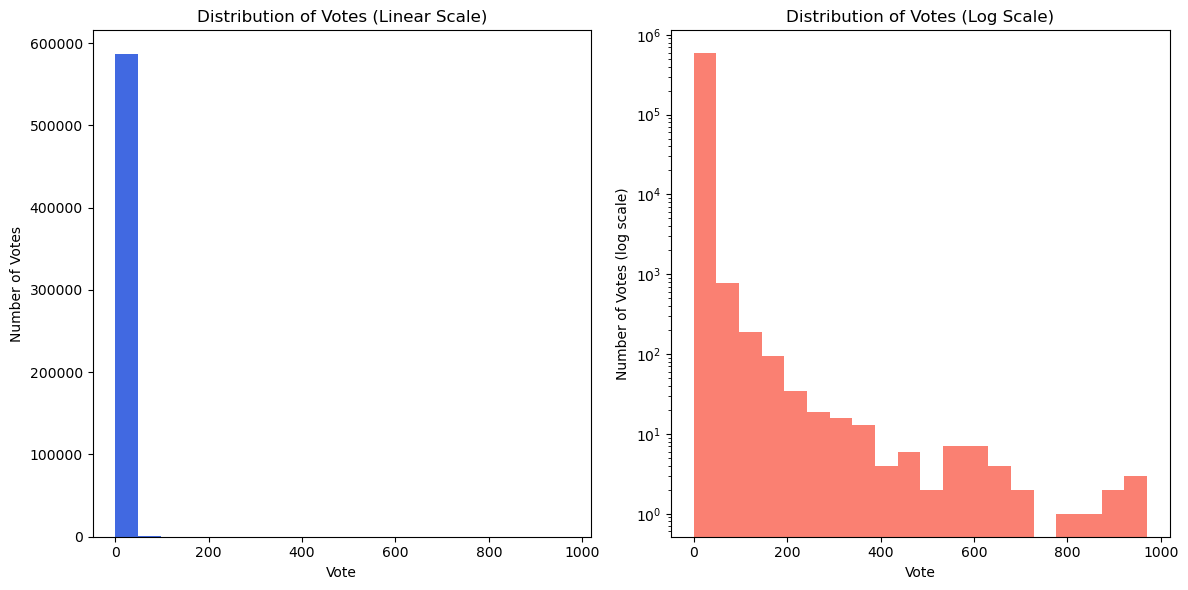

In [38]:
# Creating a figure and axis objects for subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Distribution of votes (linear scale)
axs[0].hist(appliances_df_working_dedup_filter['vote_clean'], bins=20, color='royalblue')
axs[0].set_xlabel("Vote")
axs[0].set_ylabel("Number of Votes")
axs[0].set_title("Distribution of Votes (Linear Scale)")

# Subplot 2: Distribution of votes (log scale)
axs[1].hist(appliances_df_working_dedup_filter['vote_clean'], bins=20, color='salmon', log=True)
axs[1].set_xlabel("Vote")
axs[1].set_ylabel("Number of Votes (log scale)")
axs[1].set_title("Distribution of Votes (Log Scale)")

# Adjust layout to prevent overlapping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Cross tab of vote counts
# Cross tabulation of vote counts
print(appliances_df_working_dedup_filter['vote_clean'].value_counts().sort_index(ascending=True))

vote_clean
0.0      528014
2.0       20106
3.0       10338
4.0        6090
5.0        4029
          ...  
894.0         1
915.0         1
927.0         1
930.0         1
970.0         1
Name: count, Length: 279, dtype: int64


In [39]:
# Creating our dependent variable 'helpfulness_binary' with the following conditions
# 1 if Votes > 0 and verified is True
# 0 otherwise
appliances_df_working_dedup_filter['helpfulness_binary'] = appliances_df_working_dedup_filter[['vote_clean', 'verified_clean']].apply(lambda x:
                                                        1 if x['vote_clean'] > 0
                                                        and x['verified_clean'] else 0,
                                                        axis=1)

# Checking counts
print(appliances_df_working_dedup_filter['helpfulness_binary'].value_counts().sort_index(ascending=True))

helpfulness_binary
0    540331
1     47005
Name: count, dtype: int64


In [40]:
# Calculating the total number of entries
total_entries = len(appliances_df_working_dedup_filter)

# Calculating the count'helpfulness_binary'
helpfulness_counts = appliances_df_working_dedup_filter['helpfulness_binary'].value_counts()

# Calculating the percentage of each category
percentage_1 = (helpfulness_counts[1] / total_entries) * 100
percentage_0 = (helpfulness_counts[0] / total_entries) * 100

# Printing the percentages
print("Percentage of Helpfulness", percentage_1)
print("Percentage of Not helpfulness", percentage_0)

Percentage of Helpfulness 8.003085116526146
Percentage of Not helpfulness 91.99691488347386


Helpfulness is 8% and 92% is not helpful

### Stratified sampling

In [41]:
# Stratified sampling
def stratified_sampling(data, sample_size, feature_list):

    strata_counts = data.groupby(feature_list).size()

    # Calculating target sample sizes for each stratum (proportional to population)
    total_count = strata_counts.sum()
    strata_sample_sizes = (strata_counts / total_count * sample_size).round().astype(int)

    # Sample calculation of reviews from each stratum
    sampled_reviews = []
    for stratum, size in strata_sample_sizes.items():
        # Checking if sample size for the stratum is 0
        if size == 0:
            continue  # Skip sampling for this stratum

        stratum_reviews = data[data[feature_list].eq(stratum).all(axis=1)]
        # Adjusting sample size if it's larger than the number of items available in the stratum
        # taking max may lead to oversampling
        # min will be more accurate
        size = min(size, len(stratum_reviews))
        # Random sampling within the stratum
        # replace=False ensures that same datapoint isn't sampled twice
        sampled_stratum = stratum_reviews.sample(n=size, replace=False)
        sampled_reviews.append(sampled_stratum)

    # Concatenating sampled reviews
    if sampled_reviews:
        sampled_df = pd.concat(sampled_reviews)
    else:
        sampled_df = pd.DataFrame(columns=data.columns)  # Creating an empty DataFrame if no samples are selected

    return sampled_df

In [42]:
appliances_df_working_dedup_filter.dtypes

overall                        int64
vote                          object
verified                        bool
reviewTime                    object
reviewerID                    object
asin                          object
style                         object
reviewerName                  object
reviewText                    object
summary                       object
unixReviewTime                 int64
image                         object
reviewTime_cleaned    datetime64[ns]
review_year                    int32
review_month                   int32
review_day                     int32
verified_clean                  bool
vote_clean                   float64
image_available                 bool
helpfulness_binary             int64
dtype: object

In [43]:
appliances_df_working_dedup_filter.shape

(587336, 20)

#### Since our data is huge we are doing stratified sampling on 50000 of the data

In [44]:
# Specifying the strata features
strata_feature_list = ["helpfulness_binary", # dependent variable as strata to ensure class balance remains
                       # month and year as strata to ensure sample is representative of seasonality and review age
                       "review_year",
                       "review_month",
                       # image availability strata to ensure sample is representative of overall population
                       "image_available" ]
                       # asin is computationally expensive and is not required
                       # asin as strata to ensure sample is representative of overall product-review distribution
                       #"asin"]

# Specifying total sample volume
final_data_sample_size = 50000

appliances_df_working_dedup_filter_sample = stratified_sampling(appliances_df_working_dedup_filter,
                                                              final_data_sample_size, strata_feature_list)

In [45]:
appliances_df_working_dedup_filter_sample.shape

(49995, 20)

In [46]:
# Checking counts
print(appliances_df_working_dedup_filter_sample['helpfulness_binary'].value_counts().sort_index(ascending=True))

helpfulness_binary
0    45995
1     4000
Name: count, dtype: int64


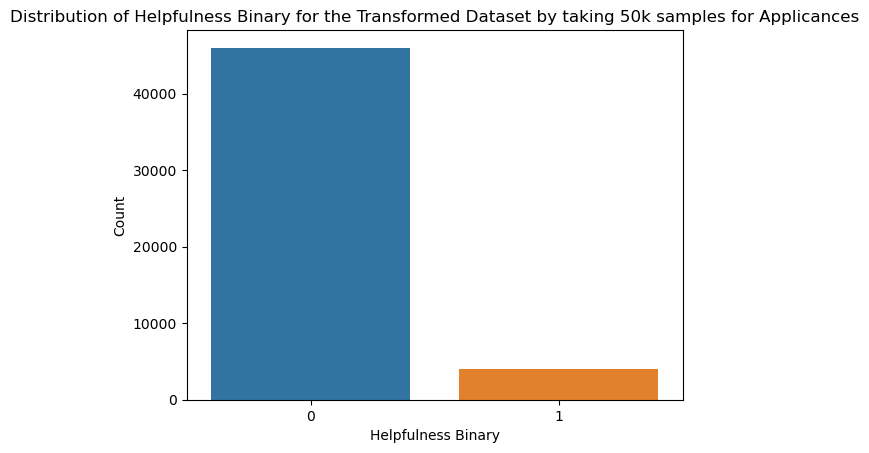

In [47]:
# Plot the distribution of 'helpfulness_binary'
sns.countplot(x='helpfulness_binary', data=appliances_df_working_dedup_filter_sample)
plt.title('Distribution of Helpfulness Binary for the Transformed Dataset by taking 50k samples for Applicances')
plt.xlabel('Helpfulness Binary')
plt.ylabel('Count')
plt.show()

### After stratified sampling checking if the distribution of helpfulness is same as the population

In [48]:
# Calculating the total number of entries for sample data
total_entries = len(appliances_df_working_dedup_filter_sample)

# Calculating the count'helpfulness_binary' for sample data
helpfulness_counts = appliances_df_working_dedup_filter_sample['helpfulness_binary'].value_counts()

# Calculating the percentage of each category for sample data
percentage_1 = (helpfulness_counts[1] / total_entries) * 100
percentage_0 = (helpfulness_counts[0] / total_entries) * 100

# Printing the percentages for sample data
print("Percentage of Helpfulness", percentage_1)
print("Percentage of Not helpfulness", percentage_0)


Percentage of Helpfulness 8.000800080008002
Percentage of Not helpfulness 91.99919991999201


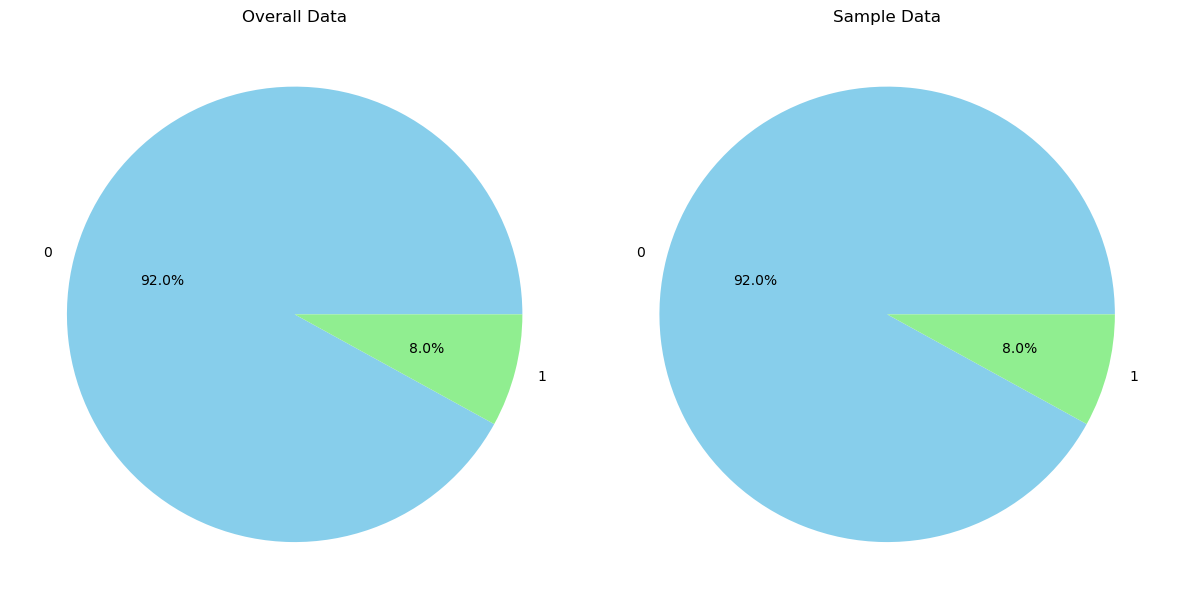

In [49]:
# Calculate counts for each category in the overall Data
overall_counts = appliances_df_working_dedup_filter['helpfulness_binary'].value_counts()

# Calculate counts for each category in the sample Data
sample_counts = appliances_df_working_dedup_filter_sample['helpfulness_binary'].value_counts()

# Pie Chart
plt.figure(figsize=(12, 6))

# Plot pie chart for the overall DataFrame
plt.subplot(1, 2, 1)
plt.pie(overall_counts, labels=overall_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Overall Data')

# Plot pie chart for the sample DataFrame
plt.subplot(1, 2, 2)
plt.pie(sample_counts, labels=sample_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Sample Data')

plt.tight_layout()
plt.show()

#### I can conclude sample data is same as overall population

In [50]:
appliances_df_working_dedup_filter_sample.dtypes

overall                        int64
vote                          object
verified                        bool
reviewTime                    object
reviewerID                    object
asin                          object
style                         object
reviewerName                  object
reviewText                    object
summary                       object
unixReviewTime                 int64
image                         object
reviewTime_cleaned    datetime64[ns]
review_year                    int32
review_month                   int32
review_day                     int32
verified_clean                  bool
vote_clean                   float64
image_available                 bool
helpfulness_binary             int64
dtype: object

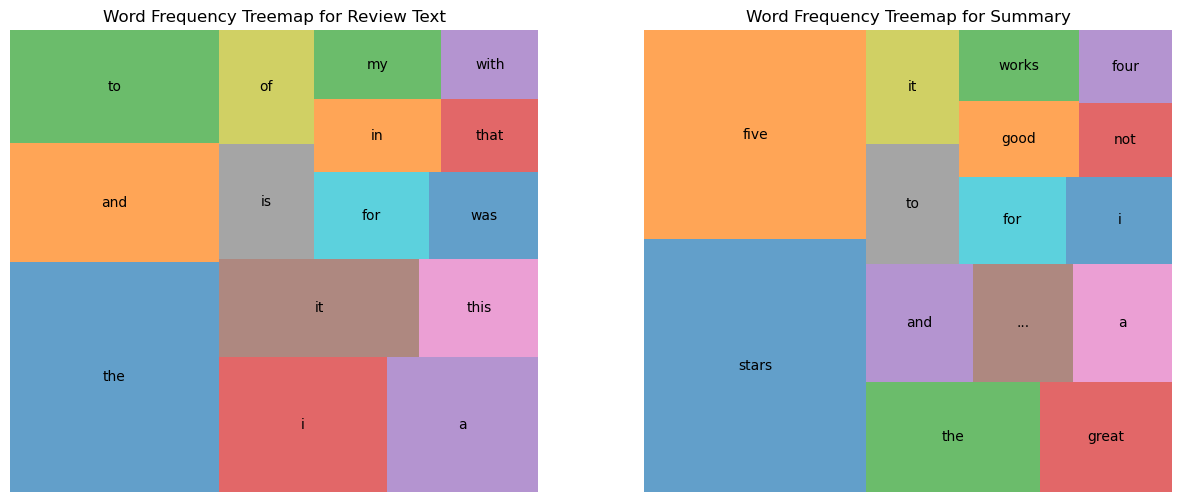

In [52]:
# Setting text and summary parameters
review_text = appliances_df_working_dedup_filter_sample["reviewText"]
summary_text = appliances_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

# Define custom colors for the treemap
custom_colors = sns.color_palette('tab10', n_colors=top_n)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create treemap for review text
squarify.plot(sizes=review_sizes, label=review_labels, alpha=0.7, color=custom_colors, ax=axes[0])
axes[0].set_title('Word Frequency Treemap for Review Text')

# Create treemap for summary
squarify.plot(sizes=summary_sizes, label=summary_labels, alpha=0.7, color=custom_colors, ax=axes[1])
axes[1].set_title('Word Frequency Treemap for Summary')

# Turn off axis for both plots
for ax in axes:
    ax.axis('off')

# Show plots
plt.show()


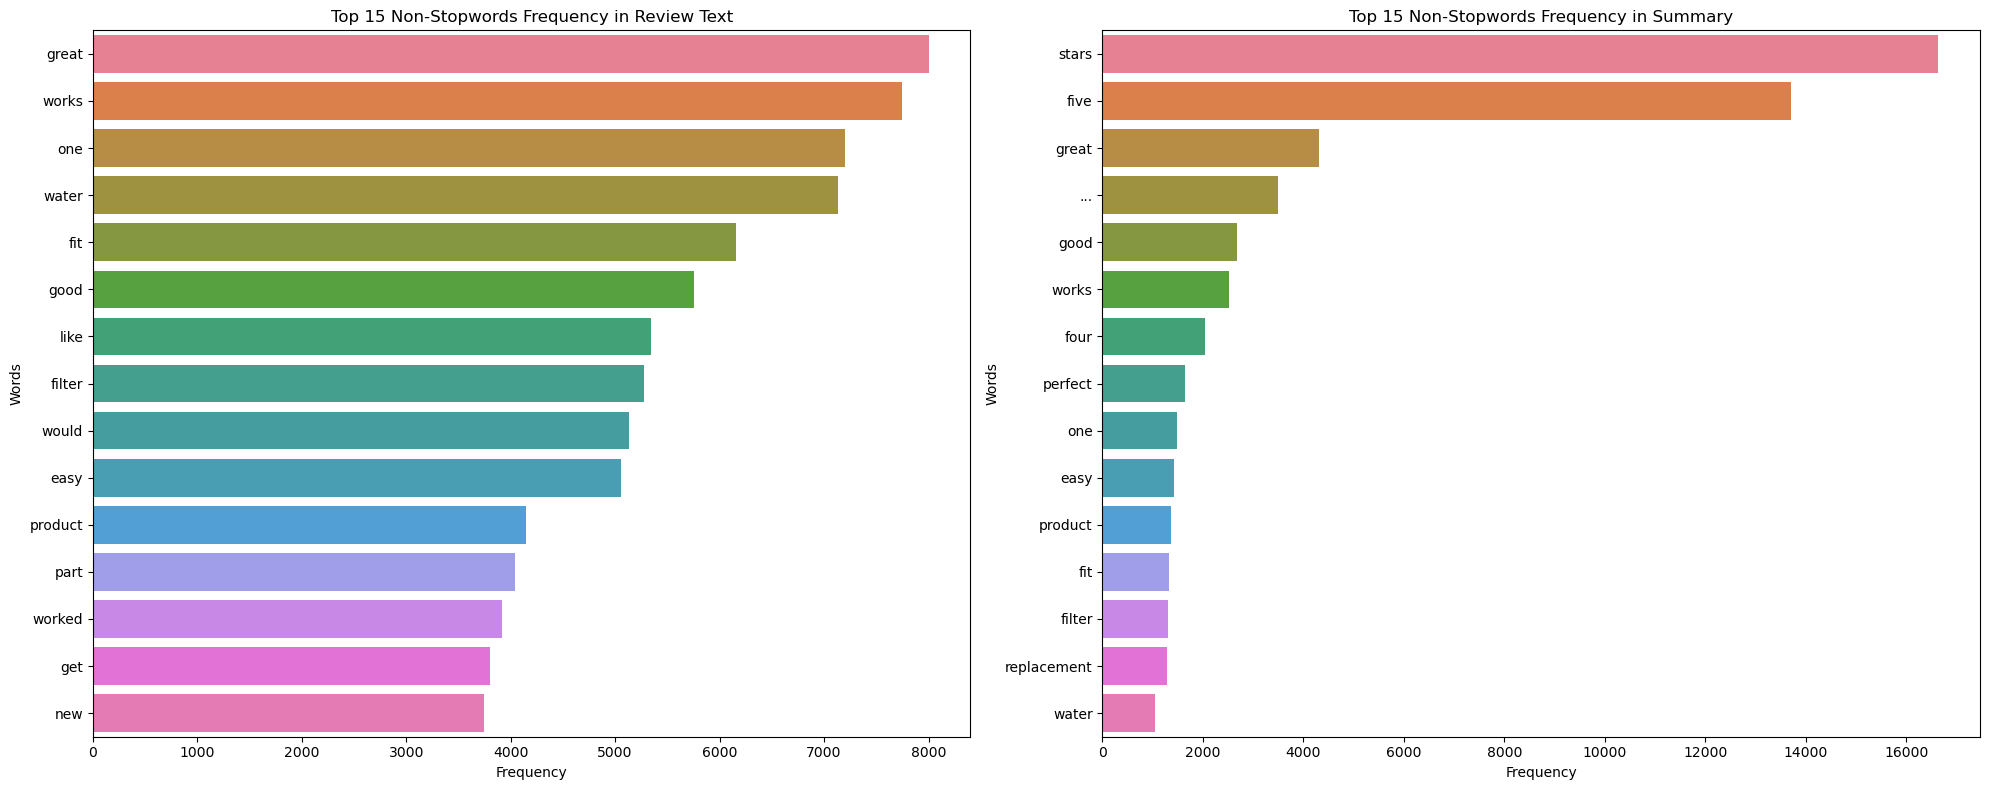

In [53]:
# Setting text and summary parameters
review_text = appliances_df_working_dedup_filter_sample["reviewText"]
summary_text = appliances_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Get NLTK stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from review text
review_words = [word for word in review_words if word not in stop_words]

# Remove stopwords from summary
summary_words = [word for word in summary_words if word not in stop_words]

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_counts = [word[1] for word in most_common_review_words]

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_counts = [word[1] for word in most_common_summary_words]

custom_palette = sns.color_palette('husl', n_colors=top_n)

# Create bar chart for review text
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.barplot(x=review_counts, y=review_labels, palette=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Review Text')
plt.xlabel('Frequency')
plt.ylabel('Words')

# Create bar chart for summary
plt.subplot(1, 2, 2)
sns.barplot(x=summary_counts, y=summary_labels, palette=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Summary')
plt.xlabel('Frequency')
plt.ylabel('Words')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

## Data Transformation and Feature engineering

#### 1) Review title (summary) metadata:
1a) # words in title

1b) # length of original title

1c) Title sentiment

1d) Unique word count

1e) Emoji & non-ASCII character count

1f) Term frequency/TFIDF of the cleaned title with prefix of title if summary is not similar to text (might be tricky to do)

#### 2) Review text (reviewText) metadata:
2a) # words in review

2b) # length of original review

2c) Review sentiment

2d) Unique word count

2e) URL availability inside reviewtext

2f) Stop word count  

2g) Emoji & non-ASCII character count

#### 3) Age of review: (end of 2018 - review posted date) = review age in days

#### 4) Review text cleaning:
4a) convert reviewtext to lowercase, remove double spaces, punctuations, numbers

4b) Expand I've, We're to I have, We have etc.

4c) Remove URLs, stopwords (standard and custom), non-ASCII characters, emojis and other non-printable characters

4d) Remove sparse words

4e) Lemmatization

4f) n-grams: Check for top unigrams and bigrams 

In [54]:
# Function definitions

# Function for number of words in input text
def num_words(text):
    return len(word_tokenize(text))

# Function to get length of input text
def text_length(text):
    return len(text)

# Sentiment polarity
# <0 indicates negative sentiment
# 0 indicates netural
# >0 indicates positive sentiment
def text_sentiment(title):
    blob = TextBlob(title)
    return blob.sentiment.polarity

# Function to get count of unique words in the input text
def unique_word_count(text):
    return len(set(word_tokenize(text)))

# If UNICODE_EMOJI isn't getting installed, use this version of the function
# This uses a regex pattern to capture non-alphanumeric characters
def emoji_and_non_ascii_count(text):
    emoji_pattern = r"[^a-zA-Z0-9\s+\.\!]"
    return len(re.findall(emoji_pattern, text))

# Function to count the number of URLs inside the input text
def url_count(text):
    url_pattern = r"http[s]?://\S+"  # Regular expression for URLs
    return len(re.findall(url_pattern, text))

# Function to count the number of English stopwords in the input text
def stopword_count(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return sum(word in stop_words for word in words)

#### 1) Review title (summary) metadata:

In [55]:
# Creating features 1a - 1e

# 1a: Number of words in the review title
appliances_df_working_dedup_filter_sample['num_words_review_title'] = appliances_df_working_dedup_filter_sample['summary'].apply(num_words)

# 1b. length of original review title
appliances_df_working_dedup_filter_sample['title_length'] = appliances_df_working_dedup_filter_sample['summary'].apply(text_length)

# 1c: Sentiment polarity of review title
appliances_df_working_dedup_filter_sample['title_sentiment'] = appliances_df_working_dedup_filter_sample['summary'].apply(text_sentiment)

# 1d: Unique word count of review title
appliances_df_working_dedup_filter_sample['unique_word_count_title'] = appliances_df_working_dedup_filter_sample['summary'].apply(unique_word_count)

# 1e: Emoji & non-ASCII character count of review title
appliances_df_working_dedup_filter_sample['emoji_non_ascii_count_title'] = appliances_df_working_dedup_filter_sample['summary'].apply(emoji_and_non_ascii_count)

# Check the dataframe
appliances_df_working_dedup_filter_sample.shape

(49995, 25)

#### 2) Review text (reviewText) metadata:

In [56]:
# Creating features 2a - 2g

# 2a: Number of words in the review text
appliances_df_working_dedup_filter_sample['num_words_review_text'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(num_words)

# 2b. length of original review text
appliances_df_working_dedup_filter_sample['review_length'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(text_length)

# 2c: Sentiment polarity of review text
appliances_df_working_dedup_filter_sample['review_sentiment'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(text_sentiment)

# 2d: Unique word count of review text
appliances_df_working_dedup_filter_sample['unique_word_count_review'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(unique_word_count)

# 2e: URL count inside review text
appliances_df_working_dedup_filter_sample['url_count_review'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(url_count)

# 2f: Stop word count of review text
appliances_df_working_dedup_filter_sample['stop_word_count_review'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(stopword_count)

# 2g: Emoji & non-ASCII character count review text
appliances_df_working_dedup_filter_sample['emoji_non_ascii_count_review'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(emoji_and_non_ascii_count)

# Check the dataframe
print(appliances_df_working_dedup_filter_sample.shape)

(49995, 32)


In [57]:
appliances_df_working_dedup_filter_sample.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,...,title_sentiment,unique_word_count_title,emoji_non_ascii_count_title,num_words_review_text,review_length,review_sentiment,unique_word_count_review,url_count_review,stop_word_count_review,emoji_non_ascii_count_review
499281,5,8,False,"01 31, 2010",AMD1T4MAUF3KN,B001PKSUWY,NaN,ZN,Our house was built late 90s with GE profile a...,A very satified customer,...,0.200000,4,0,711,3294,0.107876,318,0,259,43
57726,1,11,False,"01 3, 2010",A38RP3X51E5WHH,B000ZIKTGC,NaN,Matthew L. Jackson,"my first email...\n\nHello,I am so mad right n...",The grates will rust and then the stove top wi...,...,0.976562,10,0,539,2607,0.083913,239,0,210,32


#### 3) Age of review: (end of 2018 - review posted date) = review age in days

In [ ]:
# Calculating the end date of 2018 as the reference date since the dataset is as of 2018
end_of_2018 = datetime(2018, 12, 31)

# Converting datetime64[ns] to pandas datetime
if pd.api.types.is_datetime64_dtype(appliances_df_working_dedup_filter_sample['reviewTime_cleaned']):
    appliances_df_working_dedup_filter_sample['reviewTime_cleaned'] = pd.to_datetime(appliances_df_working_dedup_filter_sample['reviewTime_cleaned'])

# Calculating the age in days
appliances_df_working_dedup_filter_sample['review_age_days'] = (end_of_2018 - appliances_df_working_dedup_filter_sample['reviewTime_cleaned']).dt.days


In [ ]:
# Check
appliances_df_working_dedup_filter_sample.shape

(49995, 33)

#### 4: Text cleaning

In [58]:
# Defining a master function that will do the following for a provided input text:
# 4a) Lowercase and remove double spaces
# 4b) Expand contractions
# 4c) Remove unwanted characters, numbers, punctuations
# 4d) Resolving acronyms and abbreviations

def remove_urls_html_tags(text):
    # Removes URLs and HTML tags from text
    pattern = r"https?://\S+|www\.\S+|<.*?>"
    return re.sub(pattern, "", text, flags=re.MULTILINE)

def expand_contractions(text):
    # Expands contractions in text
    return contractions.fix(text)

def remove_non_ascii_and_emojis(text):
    #Removes non-ASCII characters and emojis from text
    emoji_pattern = re.compile(
        r'['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', re.sub(r'[^\x00-\x7F]+', r'', text))

def remove_punctuations_and_digits(text):
    # Removes punctuations and digits from text
    translation_table = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translation_table)

def expand_acronyms_and_abbreviations(text):
    # Expands acronyms and abbreviations in text (add more as required)."""
    acronyms_abbrs = {
        "tbh": "to be honest",
        "2mw": "tomorrow",
        "lol": "laugh out loud",
        "fyi": "for your information",
        "acct": "account",
        "adih": "another day in hell",
        "afaic": "as far as i am concerned",
        "afaict": "as far as i can tell",
        "afaik": "as far as i know",
        "afair": "as far as i remember",
        "afk": "away from keyboard",
        "gr8": "great",
        "omg": "oh my god",
        "omw": "on my way"
    }

    for acronym, full_form in acronyms_abbrs.items():
        text = text.replace(acronym, full_form)

    return text

def remove_stopwords(text):
    # Removes stopwords from text (add custom stopwords to the list)
    custom_stopwords = ["amazon", "order", "also"]
    stop_words = stopwords.words("english") + custom_stopwords
    return " ".join([word for word in text.split() if word not in stop_words])

def lemmatize_text(text):
    # Lemmatizes text to its base form
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def clean_text_master_function(text):
    # Cleans text by performing various text cleaning steps
    text = text.lower()
    text = text.replace(" ", " ")  # Remove double spaces
    text = remove_urls_html_tags(text)
    text = remove_non_ascii_and_emojis(text)
    text = remove_punctuations_and_digits(text)
    text = expand_contractions(text)
    text = expand_acronyms_and_abbreviations(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text


In [59]:
# Applying the cleaning function to the reviewText column
appliances_df_working_dedup_filter_sample['review_text_clean'] = appliances_df_working_dedup_filter_sample['reviewText'].apply(clean_text_master_function)

In [60]:
appliances_df_working_dedup_filter_sample['review_text_clean'].shape

(49995,)

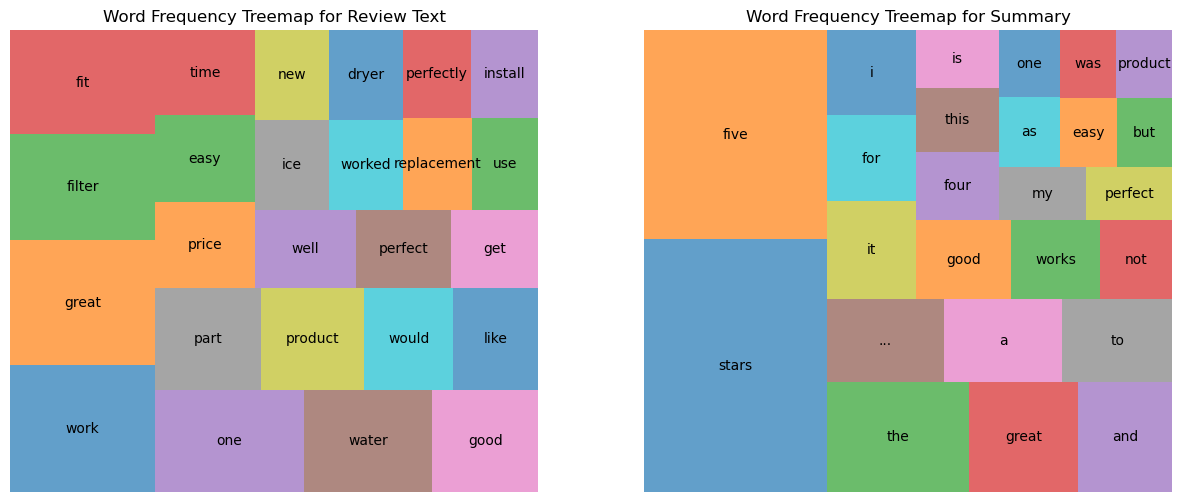

In [61]:
# Setting text and summary parameters
review_text = appliances_df_working_dedup_filter_sample["review_text_clean"]
summary_text = appliances_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 25
most_common_review_words = review_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

# Define custom colors for the treemap
custom_colors = sns.color_palette('tab10', n_colors=top_n)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create treemap for review text
squarify.plot(sizes=review_sizes, label=review_labels, alpha=0.7, color=custom_colors, ax=axes[0])
axes[0].set_title('Word Frequency Treemap for Review Text')

# Create treemap for summary
squarify.plot(sizes=summary_sizes, label=summary_labels, alpha=0.7, color=custom_colors, ax=axes[1])
axes[1].set_title('Word Frequency Treemap for Summary')

# Turn off axis for both plots
for ax in axes:
    ax.axis('off')

# Show plots
plt.show()

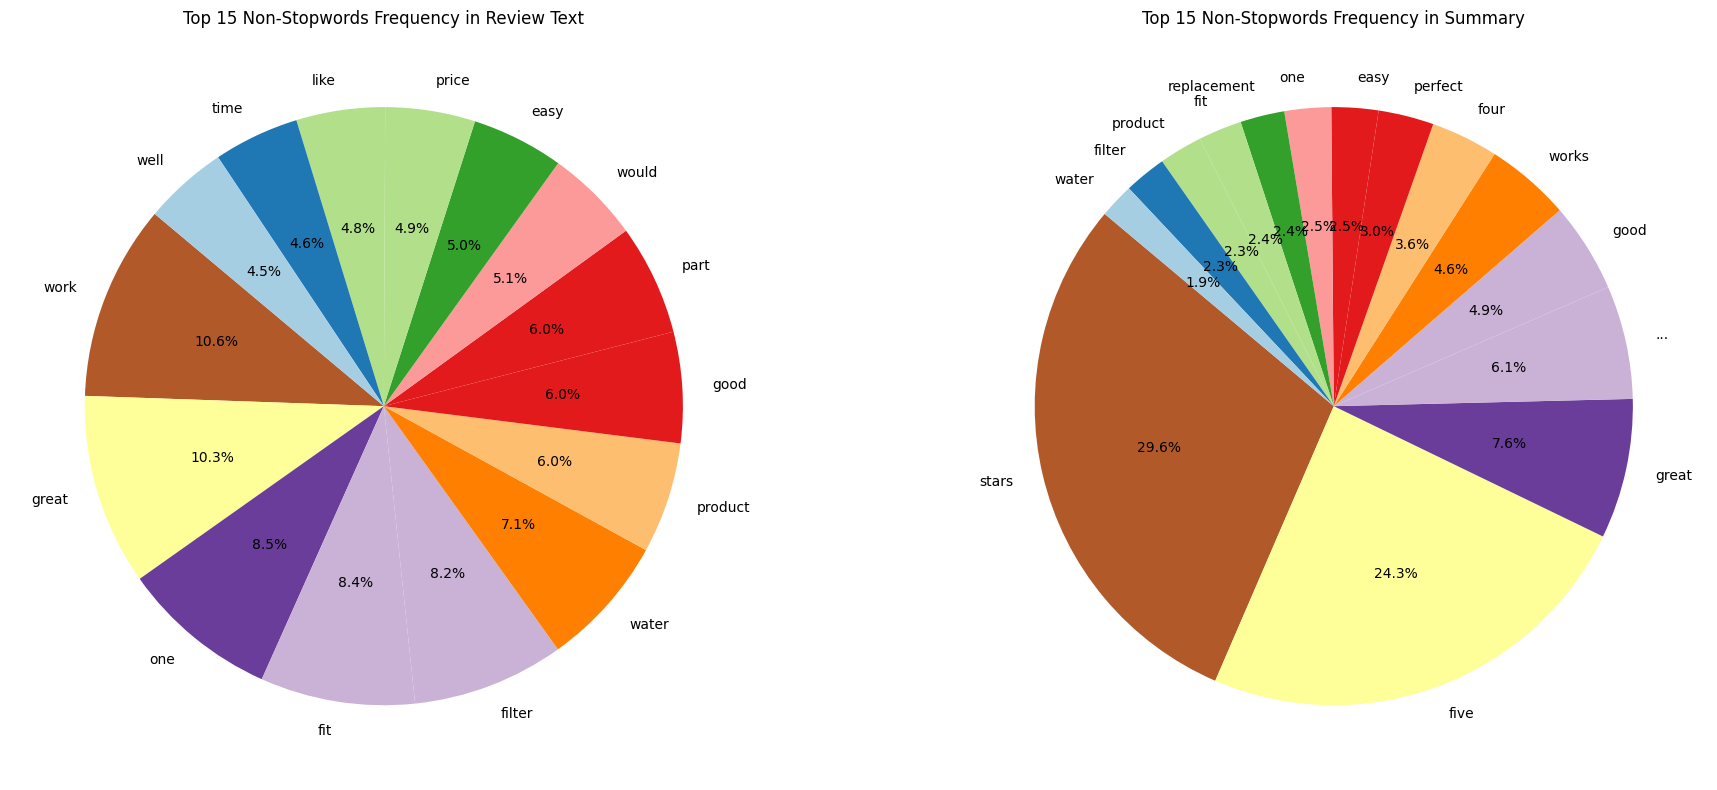

In [ ]:
#Setting text and summary parameters
review_text = appliances_df_working_dedup_filter_sample["review_text_clean"]
summary_text = appliances_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Get NLTK stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from review text
review_words = [word for word in review_words if word not in stop_words]

# Remove stopwords from summary
summary_words = [word for word in summary_words if word not in stop_words]

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

custom_palette = sns.color_palette('Paired_r', n_colors=top_n)

# Create pie chart for review text
plt.figure(figsize=(20, 8
                    ))
plt.subplot(1, 2, 1)
plt.pie(review_sizes, labels=review_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Review Text')

# Create pie chart for summary
plt.subplot(1, 2, 2)
plt.pie(summary_sizes, labels=summary_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Summary')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

#### Sentiment Analysis

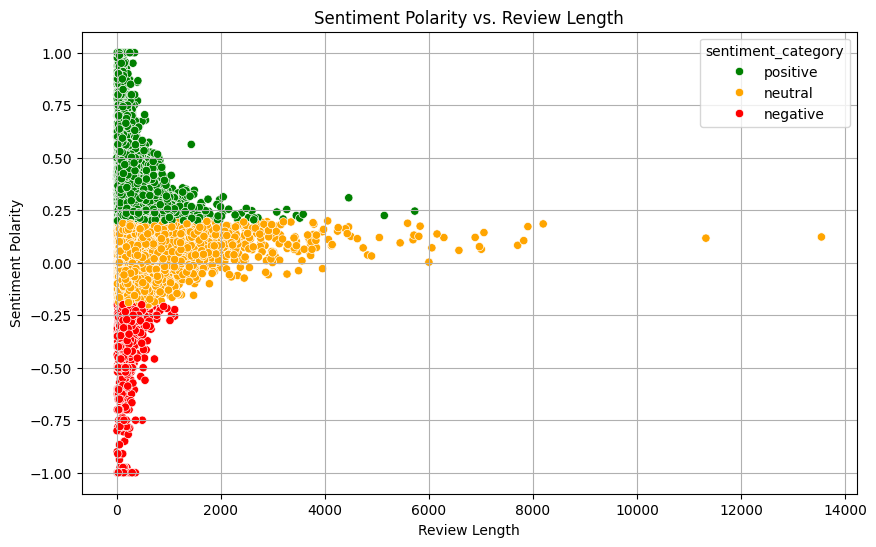

In [ ]:
review_data = appliances_df_working_dedup_filter_sample

# Define thresholds for positive, negative, and neutral sentiment
positive_threshold = 0.2
negative_threshold = -0.2

# Function to categorize sentiment polarity based on thresholds
def categorize_sentiment(polarity):
    if polarity >= positive_threshold:
        return 'positive'
    elif polarity <= negative_threshold:
        return 'negative'
    else:
        return 'neutral'

# Categorize sentiment based on polarity thresholds
review_data['sentiment_category'] = review_data['review_sentiment'].apply(categorize_sentiment)

# Plot scatter plot of sentiment polarity vs. review length with color-coded polarity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=review_data, x='review_length', y='review_sentiment', hue='sentiment_category', palette={'positive': 'green', 'negative': 'red', 'neutral': 'orange'})
plt.title('Sentiment Polarity vs. Review Length')
plt.xlabel('Review Length')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.show()

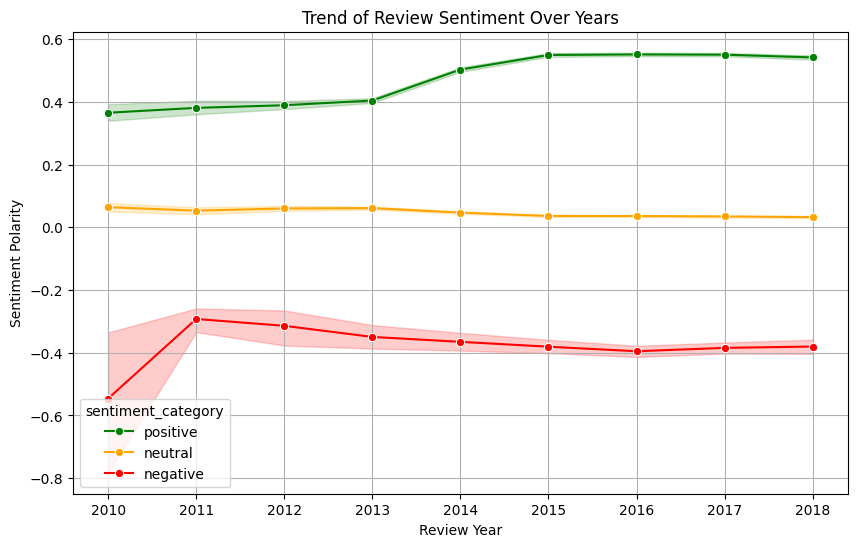

In [ ]:
review_data = appliances_df_working_dedup_filter_sample

# Function to get sentiment category based on polarity
def get_sentiment_category(polarity):
    if polarity <= -0.2:
        return 'negative'
    elif polarity >= 0.2:
        return 'positive'
    else:
        return 'neutral'

# Define custom color palette
custom_palette = {'positive': 'green', 'negative': 'red', 'neutral': 'orange'}

# Categorize sentiment polarity into positive, negative, and neutral
review_data['sentiment_category'] = review_data['review_sentiment'].apply(get_sentiment_category)

# Plot distinct lines for positive, negative, and neutral sentiment scores over the years
plt.figure(figsize=(10, 6))
sns.lineplot(data=review_data, x='review_year', y='review_sentiment', hue='sentiment_category', palette=custom_palette, marker='o')
plt.title('Trend of Review Sentiment Over Years')
plt.xlabel('Review Year')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.show()

In [ ]:
appliances_df_working_dedup_filter_sample.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image', 'reviewTime_cleaned', 'review_year', 'review_month',
       'review_day', 'verified_clean', 'vote_clean', 'image_available',
       'helpfulness_binary', 'num_words_review_title', 'title_length',
       'title_sentiment', 'unique_word_count_title',
       'emoji_non_ascii_count_title', 'num_words_review_text', 'review_length',
       'review_sentiment', 'unique_word_count_review', 'url_count_review',
       'stop_word_count_review', 'emoji_non_ascii_count_review',
       'review_age_days', 'review_text_clean', 'sentiment_category'],
      dtype='object')

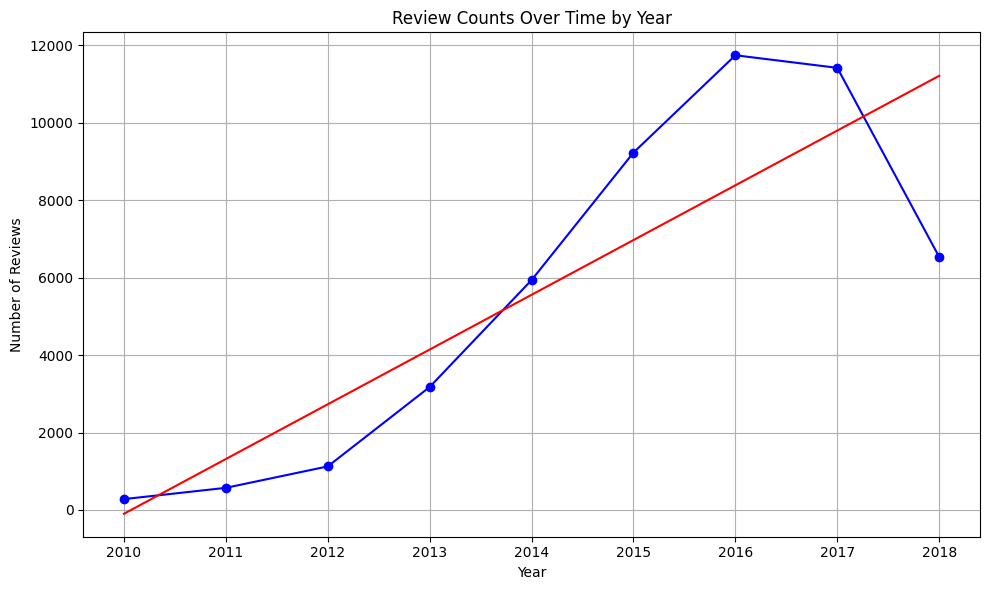

In [ ]:
# Group by year and count reviews
review_counts_by_year = appliances_df_working_dedup_filter_sample.groupby('review_year').size()

# Plot the trend line
plt.figure(figsize=(10, 6))
review_counts_by_year.plot(marker='o', color='b', linestyle='-')
plt.title('Review Counts Over Time by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(review_counts_by_year.index)  # Set x ticks to be the years
plt.tight_layout()

# Add trend line
z = np.polyfit(review_counts_by_year.index, review_counts_by_year.values, 1)
p = np.poly1d(z)
plt.plot(review_counts_by_year.index, p(review_counts_by_year.index), color='r')

plt.show()

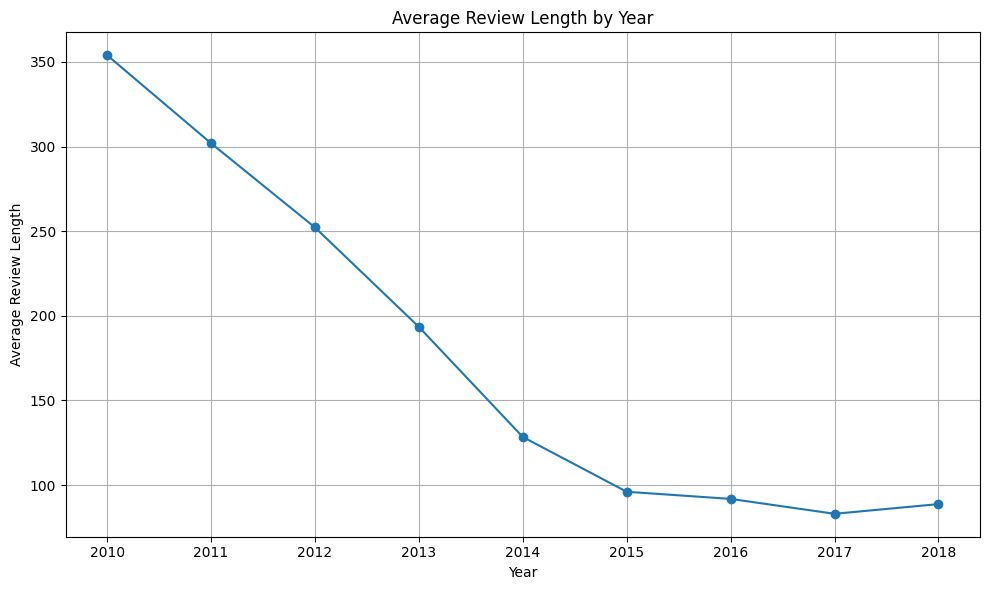

In [ ]:
# Calculate review length for each review
appliances_df_working_dedup_filter_sample['review_length'] = appliances_df_working_dedup_filter_sample['review_text_clean'].apply(len)

# Group by year and calculate average review length
average_review_length_by_year = appliances_df_working_dedup_filter_sample.groupby('review_year')['review_length'].mean()

# Plot the average review length by year
plt.figure(figsize=(10, 6))
plt.plot(average_review_length_by_year.index, average_review_length_by_year.values, marker='o', linestyle='-')
plt.title('Average Review Length by Year')
plt.xlabel('Year')
plt.ylabel('Average Review Length')
plt.grid(True)
plt.xticks(average_review_length_by_year.index)  # Set x ticks to be the years
plt.tight_layout()
plt.show()


In [62]:
'''
This function compares the distribution of top n-grams (unigrams or bigrams) for two groups in a DataFrame.

Args:
  df: The DataFrame containing the text data and a column for the comparison group ('helpfulness_binary').
  helpfulness_values: A list of the two values to compare (e.g., [1, 0] for helpfulness).
  n: The n-gram value (1 for unigrams, 2 for bigrams).
  top_n: Number of top n-grams to visualize (default: 20)
'''

# The function output is the visualization of the top n-grams for a given dataframe
def compare_top_ngram_distribution(df, helpfulness_values, n, top_n=20):
  # Creating TF-IDF vectorizer
    vectorizer = TfidfVectorizer(ngram_range=(n, n), lowercase=True, sublinear_tf=True)

  # Handling lists of tokens in 'review_text_clean'
    def preprocess_text(text):
        if isinstance(text, list):
            return ' '.join(text)
        else:
            return text

    # Preprocessing text and fit vectorizer
    data = df['review_text_clean'].apply(preprocess_text)
    vectorizer.fit_transform(data)

    # Getting TF-IDF scores for each helpfulness value
    tfidf_matrix = vectorizer.transform(data)
    tfidf_by_helpfulness = {val: tfidf_matrix[df['helpfulness_binary'] == val].toarray() for val in helpfulness_values}

    # Getting vocabulary
    vocabulary = vectorizer.get_feature_names_out()

    # Calculating average TF-IDF scores for top n-grams per helpfulness value
    top_ngram_scores = {}
    for val in helpfulness_values:
        tfidf_data = tfidf_by_helpfulness[val]
        top_ngram_indices = tfidf_data.sum(axis=0).argsort()[-top_n:]  # Get indices of top n words by sum of TF-IDF
        top_ngram_scores[val] = [ (vocabulary[i], tfidf_data[:, i].mean()) for i in top_ngram_indices ]
    # Plotting
    plt.figure(figsize=(10, 6))

  # Preparing data for visualization (separate lists for ngrams and TF-IDF by helpfulness)
    ngrams = []
    avg_tfidf_by_helpfulness = {}
    for val, scores in top_ngram_scores.items():
        ngrams.extend([ngram for ngram, _ in scores])  # ngram for labels
        avg_tfidf_by_helpfulness[f"Helpfulness={val}"] = [tfidf for _, tfidf in scores]

  # Sorting together by TF-IDF (descending)
    sorted_data = sorted(zip(ngrams, *avg_tfidf_by_helpfulness.values()), key=lambda x: x[1], reverse=True)
    sorted_ngrams, *sorted_tfidf_by_helpfulness = zip(*sorted_data)

  # Creating colors for each helpfulness value (adjust as needed)
    colors = ['blue', 'orange']

  # Creating clustered column chart
    x = range(len(sorted_ngrams))  # x-axis positions
    bar_width = 0.35  # Adjust bar width for better visualization
    plt.bar(x[:top_n], sorted_tfidf_by_helpfulness[0][:top_n], bar_width, label=f"Helpfulness={helpfulness_values[0]}", color=colors[0])
    plt.bar([p + bar_width for p in x[:top_n]], sorted_tfidf_by_helpfulness[1][:top_n],
            bar_width, label=f"Helpfulness={helpfulness_values[1]}", color=colors[1])

  # Setting x-axis labels with rotation for readability
    plt.xticks([p + bar_width/2 for p in x[:top_n]], sorted_ngrams[:top_n], rotation=60)
    plt.xlabel("Top N-Grams")
    plt.ylabel("Average TF-IDF Score")
    plt.title(f"Distribution of Top {n}-Gram TF-IDF Scores by Helpfulness Rating")
    plt.legend()
    plt.tight_layout()
    plt.show()


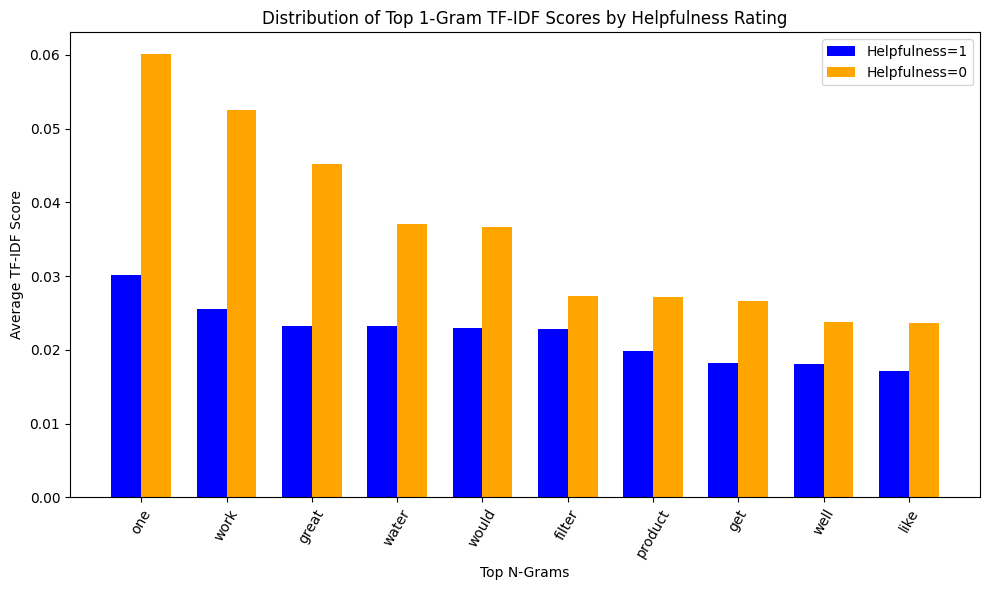

In [ ]:
helpfulness_values = [1, 0]  # List of helpfulness ratings to compare

# Compare top 10 unigram distribution
compare_top_ngram_distribution(appliances_df_working_dedup_filter_sample.copy(), helpfulness_values, 1, top_n=10)

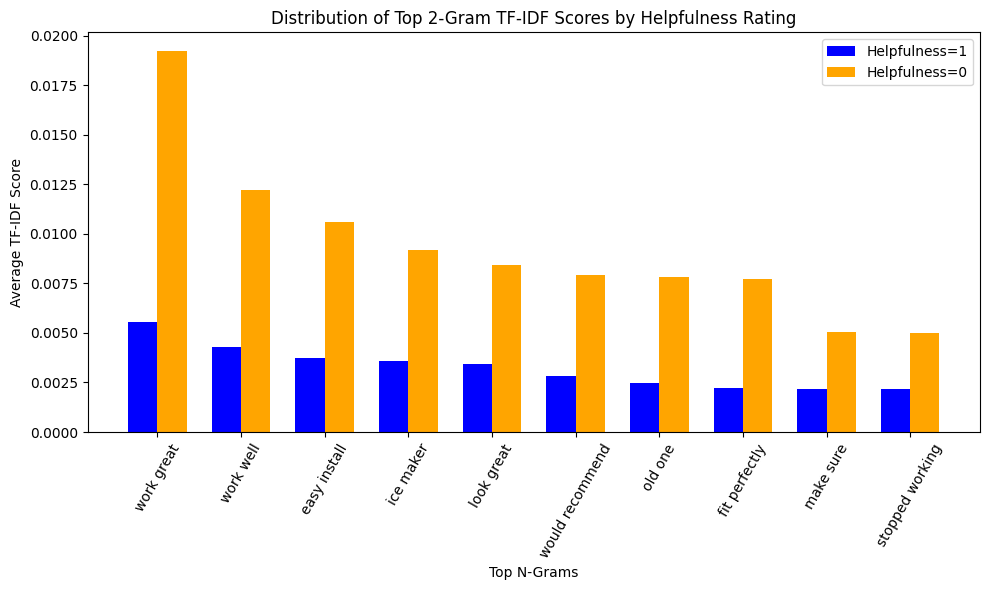

In [ ]:
# Compare top 10 bigram distribution
compare_top_ngram_distribution(appliances_df_working_dedup_filter_sample.copy(), helpfulness_values, 2, top_n=10)


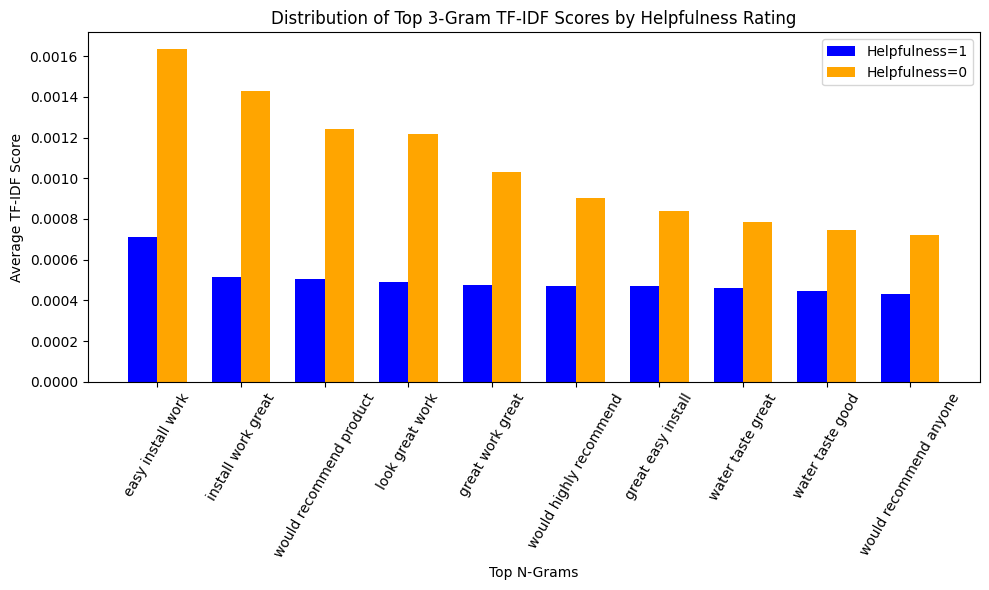

In [ ]:
# Compare top 10 trigram distribution
compare_top_ngram_distribution(appliances_df_working_dedup_filter_sample.copy(), helpfulness_values, 3, top_n=10)


## Additional plots and stats

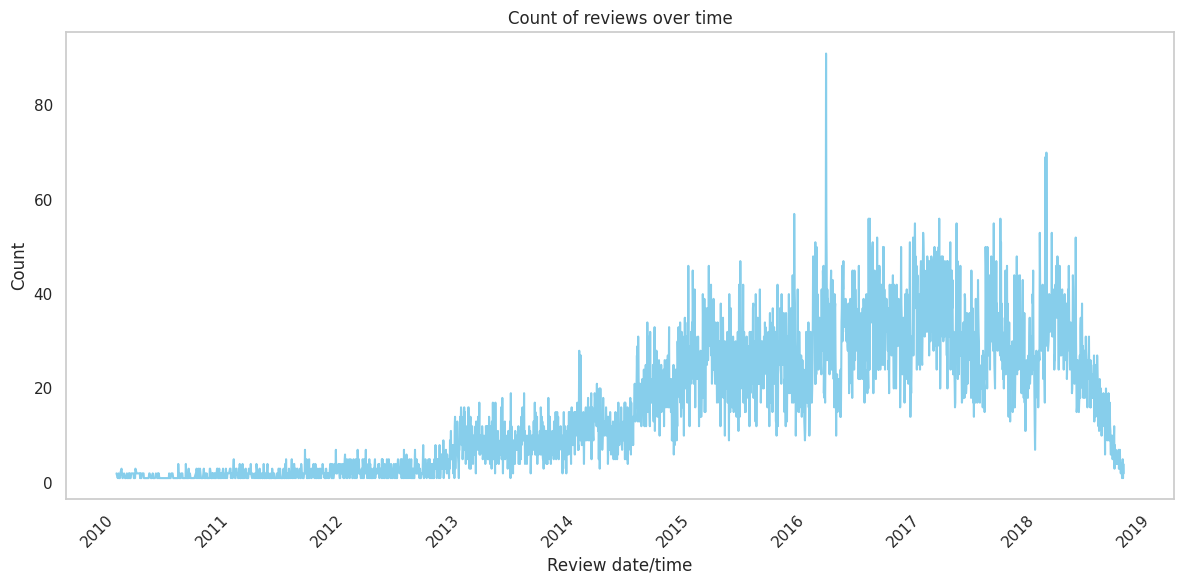

In [ ]:
# Trend chart - count of reviews over time
# This can be done on the dataset before sampling as well, change the df name accordingly

import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn plots
sns.set_style("whitegrid")

# Converting reviewTime_cleaned to datetime if it's not already in datetime format
appliances_df_working_dedup_filter_sample['reviewTime_cleaned'] = pd.to_datetime(appliances_df_working_dedup_filter_sample['reviewTime_cleaned'])

# Aggregating the data by date to reduce the number of data points in the chart
review_count_over_time = appliances_df_working_dedup_filter_sample.groupby('reviewTime_cleaned').size().reset_index(name='count')

# Plotting count of reviews over time (trend) using a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(x='reviewTime_cleaned', y='count', data=review_count_over_time, color='skyblue')
plt.title('Count of reviews over time')
plt.xlabel('Review date/time')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

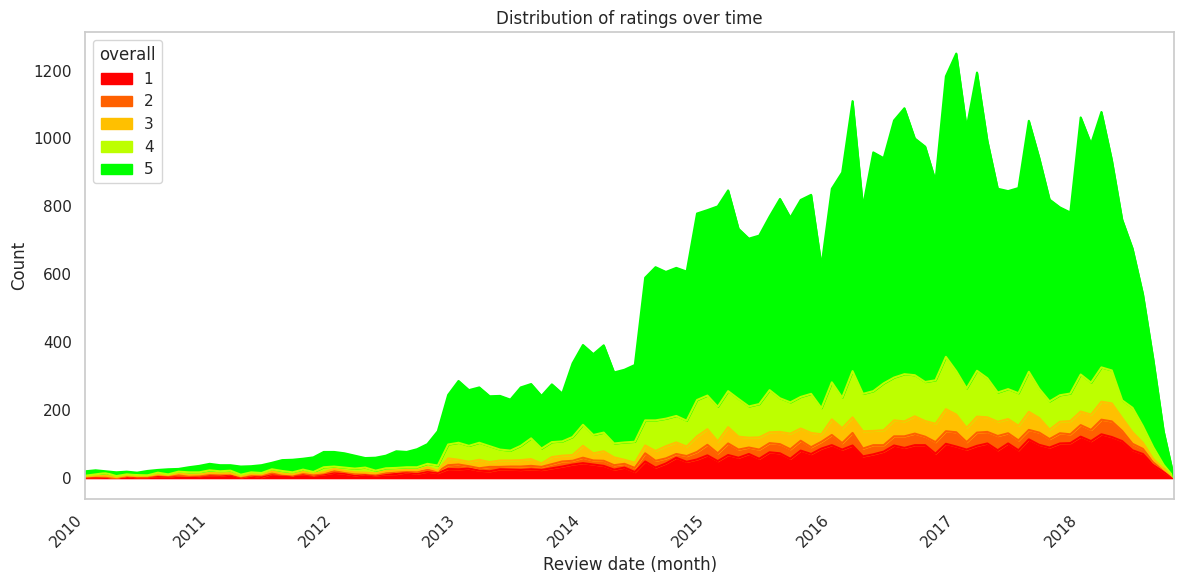

In [ ]:
# Trend chart - distribution of star rating (overall column) over time
# This can be done on the dataset before sampling as well, change the df name accordingly

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Defining the custom colormap for ratings from red to green
colors = [(1, 0, 0), (1, 0.5, 0), (1, 1, 0), (0, 1, 0)]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors)

# Aggregating the data by month and rating
ratings_over_time_agg = appliances_df_working_dedup_filter_sample.groupby([appliances_df_working_dedup_filter_sample['reviewTime_cleaned'].dt.to_period('M'), 'overall']).size().unstack().fillna(0)

# Plotting stacked bar chart for the distribution of ratings over time
plt.figure(figsize=(12, 6))
ratings_over_time_agg.plot(kind='area', stacked=True, cmap=cmap, figsize=(12, 6))
plt.title('Distribution of ratings over time')
plt.xlabel('Review date (month)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

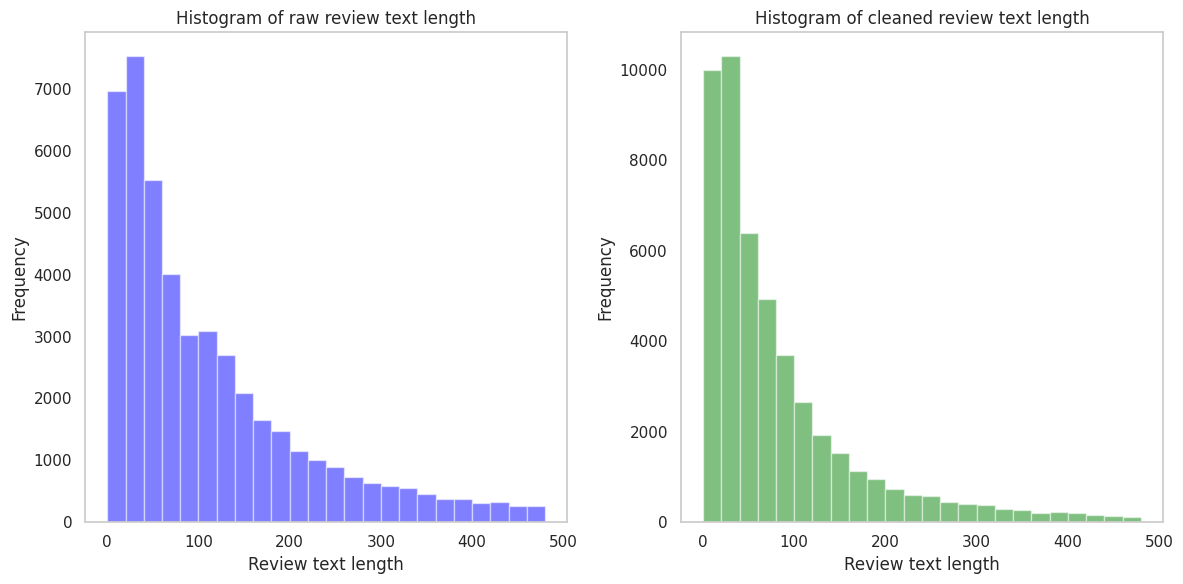

In [ ]:
# Pre and post histogram for comparing length of review text before and after cleaning is done
# We can notice the concentration of the lower review text length increases after cleaning
# i.e. relatively lower review text length become even lower
# This indicates that there are a lot of characters getting removed due to our cleaning steps
# This is because of the removal of stopwords, URLs, emojis, etc.
# X and Y axes of both charts are kept in sync to make the change visible

# Calculating the length of the text in the raw and cleaned review text columns
reviewtext_raw_lengths = appliances_df_working_dedup_filter_sample['reviewText'].apply(len)
reviewtext_cleaned_lengths = appliances_df_working_dedup_filter_sample['review_text_clean'].apply(len)

# Defining custom bins
# Bins from 0 to 500 with step size 20
custom_bins_reviewtext_len = np.arange(0, 500, 20)
# Appending infinity to include values above 500
custom_bins_reviewtext_len = np.append(custom_bins_reviewtext_len, np.inf)

# Defining subplots with same x & y axes ranges (to make the charts comparable)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plotting histogram for raw review text lengths
axes[0].hist(reviewtext_raw_lengths, bins=custom_bins_reviewtext_len, alpha=0.5, color='blue')
axes[0].set_title('Histogram of raw review text length')
axes[0].set_xlabel('Review text length')
axes[0].set_ylabel('Frequency')

# Plotting histogram for cleaned review text lengths
axes[1].hist(reviewtext_cleaned_lengths, bins=custom_bins_reviewtext_len, alpha=0.5, color='green')
axes[1].set_title('Histogram of cleaned review text length')
axes[1].set_xlabel('Review text length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

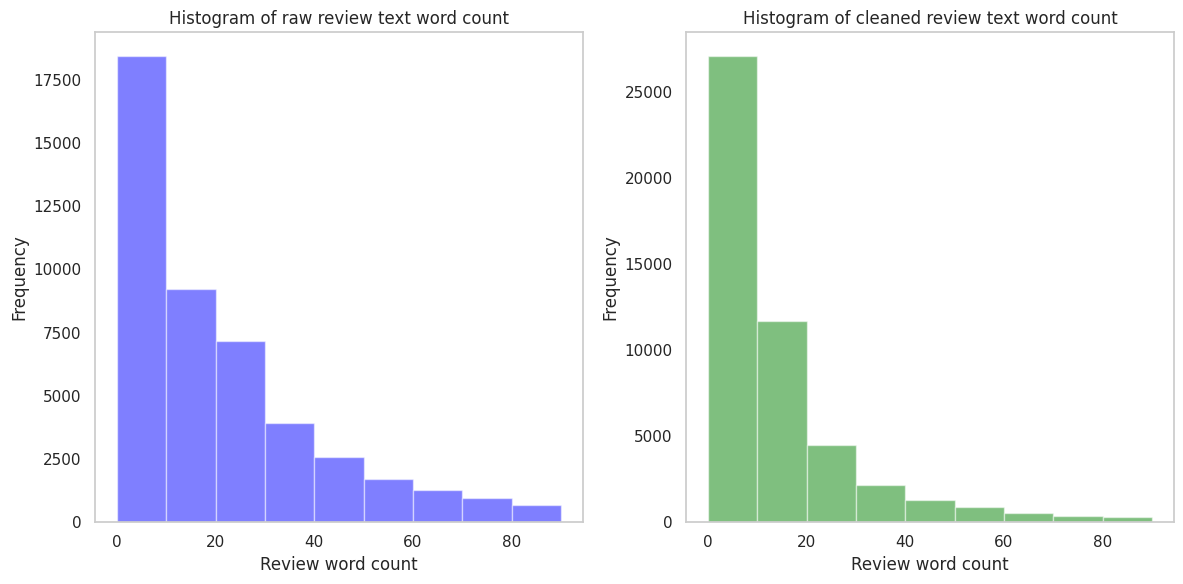

In [ ]:
# Pre and post histogram for comparing word count of review text before and after cleaning is done
# We can notice the concentration of the lower review word count increases after cleaning
# This indicates that there are a lot of words  getting removed due to our cleaning steps
# This is because of the removal of stopwords, URLs, emojis, etc.
# X and Y axes of both charts are kept in sync to make the change visible

# Calculating the word count of the text in the raw and cleaned review columns
reviewtext_raw_wordlengths = appliances_df_working_dedup_filter_sample['reviewText'].str.split().apply(len)
reviewtext_cleaned_wordlengths = appliances_df_working_dedup_filter_sample['review_text_clean'].str.split().apply(len)

# Defining custom bins
# Bins from 0 to 100 with step size 10
custom_bins_review_words = np.arange(0, 100, 10)
# Appending infinity to include values above 100
custom_bins_review_words = np.append(custom_bins_review_words, np.inf)

# Defining subplots with same x & y axes ranges (to make the charts comparable)
# This is a shared y axis
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plotting histogram for raw word counts in review text
axes[0].hist(reviewtext_raw_wordlengths, bins=custom_bins_review_words, alpha=0.5, color='blue')
axes[0].set_title('Histogram of raw review text word count')
axes[0].set_xlabel('Review word count')
axes[0].set_ylabel('Frequency')

# Plotting histogram for cleaned word counts in review text
axes[1].hist(reviewtext_cleaned_wordlengths, bins=custom_bins_review_words, alpha=0.5, color='green')
axes[1].set_title('Histogram of cleaned review text word count')
axes[1].set_xlabel('Review word count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Function to do a t-test for a given metadata feature
# When we compare the values of a feature between helpful and non helpful reviews, we want to know if the difference is statistically significant
# This can be done using a t-test
# If the p-value <0.05, we can say that the null hypothesis of no difference betweent the means can be rejected
# What this means is that there is a statistically significant difference between the feature's value between helpful and non-helpful reviews

from scipy.stats import ttest_ind

def t_test_metadata(df, metadata_column, helpfulness_column):
    # Separating data into helpful and non-helpful reviews for comparison
    helpful_reviews = df[df[helpfulness_column] == 1][metadata_column]
    non_helpful_reviews = df[df[helpfulness_column] == 0][metadata_column]

    # Performing t-test
    t_statistic, p_value = ttest_ind(helpful_reviews, non_helpful_reviews)

    return p_value

In [ ]:
# Using the t-test function
metadata_column = 'title_length'
helpfulness_column = 'helpfulness_binary'

p_value = t_test_metadata(appliances_df_working_dedup_filter_sample, metadata_column, helpfulness_column)
if p_value < 0.05:
    print(f"There is a statistically significant difference between helpful and non-helpful reviews for the {metadata_column} feature since the p-value of the difference is {p_value:.4f}")
else:
    print(f"There is no statistically significant difference between helpful and non-helpful reviews for the {metadata_column} feature since the p-value of the difference is {p_value:.4f}")

There is a statistically significant difference between helpful and non-helpful reviews for the title_length feature since the p-value of the difference is 0.0000


# Modeling

#### Steps:
1) We choose only metadata features for correlation (there will be 5k tfidf features, not feasible to check correlation)
2) Define high correlation threshold, can be >=0.85 for high positive correlation and <=-0.85 for high negative correlation
3) Check correlation matrix and exclude highly correlated unimportant features
4) Visualize correlation matrix again with final list and ensure that no two features are outside correlation thresholds
5) Create TFIDF matrix and convert to dataframe
6) Modeling dataframes - X will contain all features i.e. TFIDF features and finalized metadata features, y will contain the target variable i.e. helpfulness_binary
7) Split of modeling datasets into train (70%), test (15%), and validation (15%)
8) Training the supervised ML models; 2 sets of models will be trained - base models and tuned models
9) Base models will run with default parameters while tuned models will be run after identifying optimal parameters obtained from hyperparameter tuning
10) Compare the base and tuned models' performance
11) Compare the models
12) Feature importance of the models
13) Model explainability (extension of feature importance) and identifying drivers of helpfulness for insights
    - For tree-based models (Random Forest / XGBoost) - feature importance of review terms

### Modeling dataset creation

In [ ]:
# Specifying the metadata features for checking correlation
other_meta_features = [
                  'image_available',
                  'title_length',
                  'num_words_review_title', #'title_review_similarity', # commented if not calculated
                  'title_sentiment',
                  'unique_word_count_title',
                  'emoji_non_ascii_count_title',
                  'review_length',
                  'review_sentiment',
                  'num_words_review_text',
                  'url_count_review',
                  'unique_word_count_review',
                  'stop_word_count_review',
                  'review_age_days'
                 ]

# Getting only metadata feature columns for correlation checks
metadata_features_corr_check = appliances_df_working_dedup_filter_sample[other_meta_features]

In [ ]:
# Metadata features for correlation check
metadata_features_corr_check.columns

Index(['image_available', 'title_length', 'num_words_review_title',
       'title_sentiment', 'unique_word_count_title',
       'emoji_non_ascii_count_title', 'review_length', 'review_sentiment',
       'num_words_review_text', 'url_count_review', 'unique_word_count_review',
       'stop_word_count_review', 'review_age_days'],
      dtype='object')

In [ ]:
metadata_features_corr_check.shape

(49995, 13)

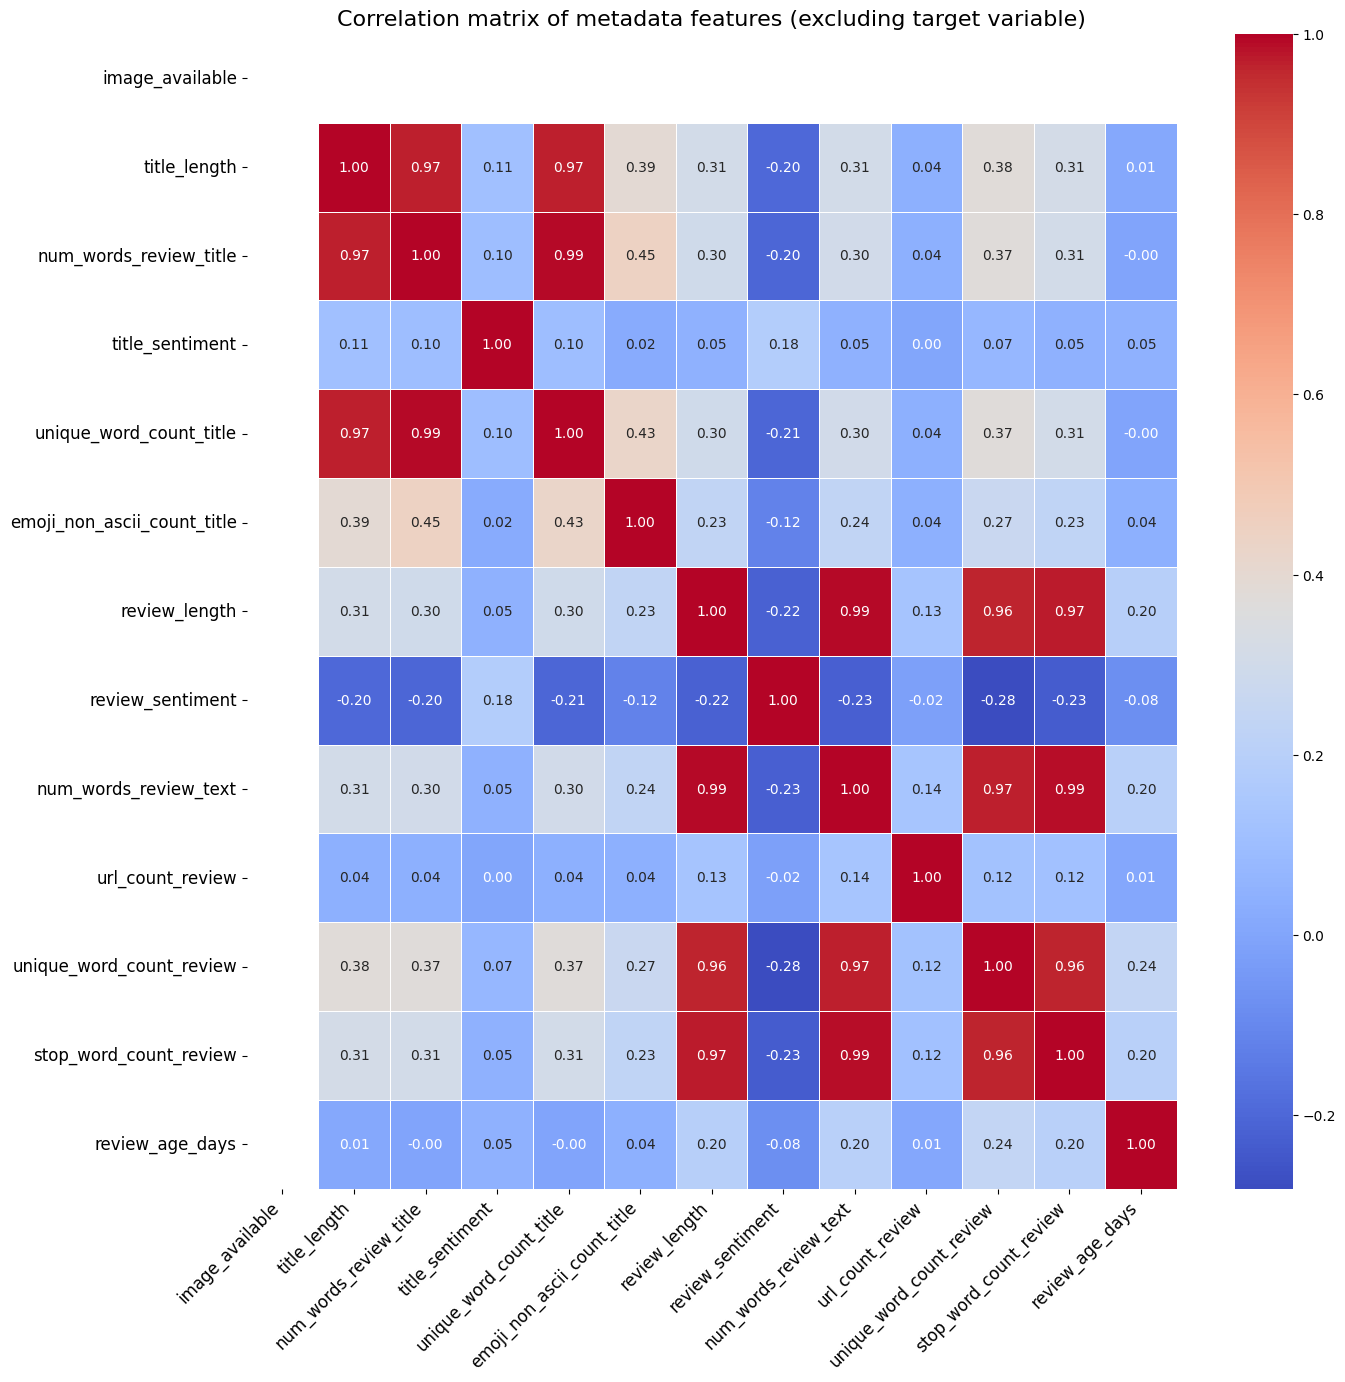

In [ ]:
# Initial correlation analysis

# Getting only metadata feature columns to check correlation
correlation_matrix_corr_check = metadata_features_corr_check.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_corr_check, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keep y-axis labels horizontal for better readability
plt.title('Correlation matrix of metadata features (excluding target variable)', fontsize=16)  # Increase title fontsize
plt.show()

In [ ]:
# After studying the above matrix and we have removed correlated metadata features
correlation_matrix_corr_check

,image_available,title_length,num_words_review_title,title_sentiment,unique_word_count_title,emoji_non_ascii_count_title,review_length,review_sentiment,num_words_review_text,url_count_review,unique_word_count_review,stop_word_count_review,review_age_days
image_available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title_length,NaN,1.000000,0.965218,0.111707,0.968065,0.392042,0.308757,-0.197320,0.308325,0.042064,0.377107,0.311707,0.010015
num_words_review_title,NaN,0.965218,1.000000,0.102342,0.991566,0.446190,0.297028,-0.203914,0.303494,0.040119,0.370418,0.308294,-0.002920
title_sentiment,NaN,0.111707,0.102342,1.000000,0.102347,0.019767,0.047704,0.183453,0.047623,0.001362,0.071629,0.046320,0.047776
unique_word_count_title,NaN,0.968065,0.991566,0.102347,1.000000,0.428282,0.296634,-0.205556,0.302436,0.041257,0.370401,0.307326,-0.004133
emoji_non_ascii_count_title,NaN,0.392042,0.446190,0.019767,0.428282,1.000000,0.234856,-0.119142,0.238377,0.040110,0.265490,0.231090,0.040283
review_length,NaN,0.308757,0.297028,0.047704,0.296634,0.234856,1.000000,-0.216453,0.991384,0.129633,0.961564,0.974027,0.196720
review_sentiment,NaN,-0.197320,-0.203914,0.183453,-0.205556,-0.119142,-0.216453,1.000000,-0.225147,-0.020474,-0.281482,-0.232675,-0.080825
num_words_review_text,NaN,0.308325,0.303494,0.047623,0.302436,0.238377,0.991384,-0.225147,1.000000,0.136515,0.969341,0.989661,0.200781
url_count_review,NaN,0.042064,0.040119,0.001362,0.041257,0.040110,0.129633,-0.020474,0.136515,1.000000,0.120366,0.117233,0.005456


#### After analysing correlation matrix, there are a lot of correlated feature. After careful examing the matrix deciding the threshold as more than 0.85. Any feature that is more than 0.85 is highly postively correlated. Any feature that is less than -0.85 is highly negatively correlated.

In [ ]:
# Removing highly negatively and postively correlated features
# Uncorrelated metadata features are identified through manual judgement i.e. heuristic approach

# Droping the columns from the dataframe
corr_columns_to_drop = ["review_length", "stop_word_count_review",
                        "unique_word_count_title","num_words_review_title","num_words_review_text",
                        # Removing image_available since it's binary/boolen and isn't relevant for correlation checks
                        "image_available"]
metadata_features_corr_check.drop(columns=corr_columns_to_drop, inplace=True)

In [ ]:
metadata_features_corr_check.shape

(49995, 7)

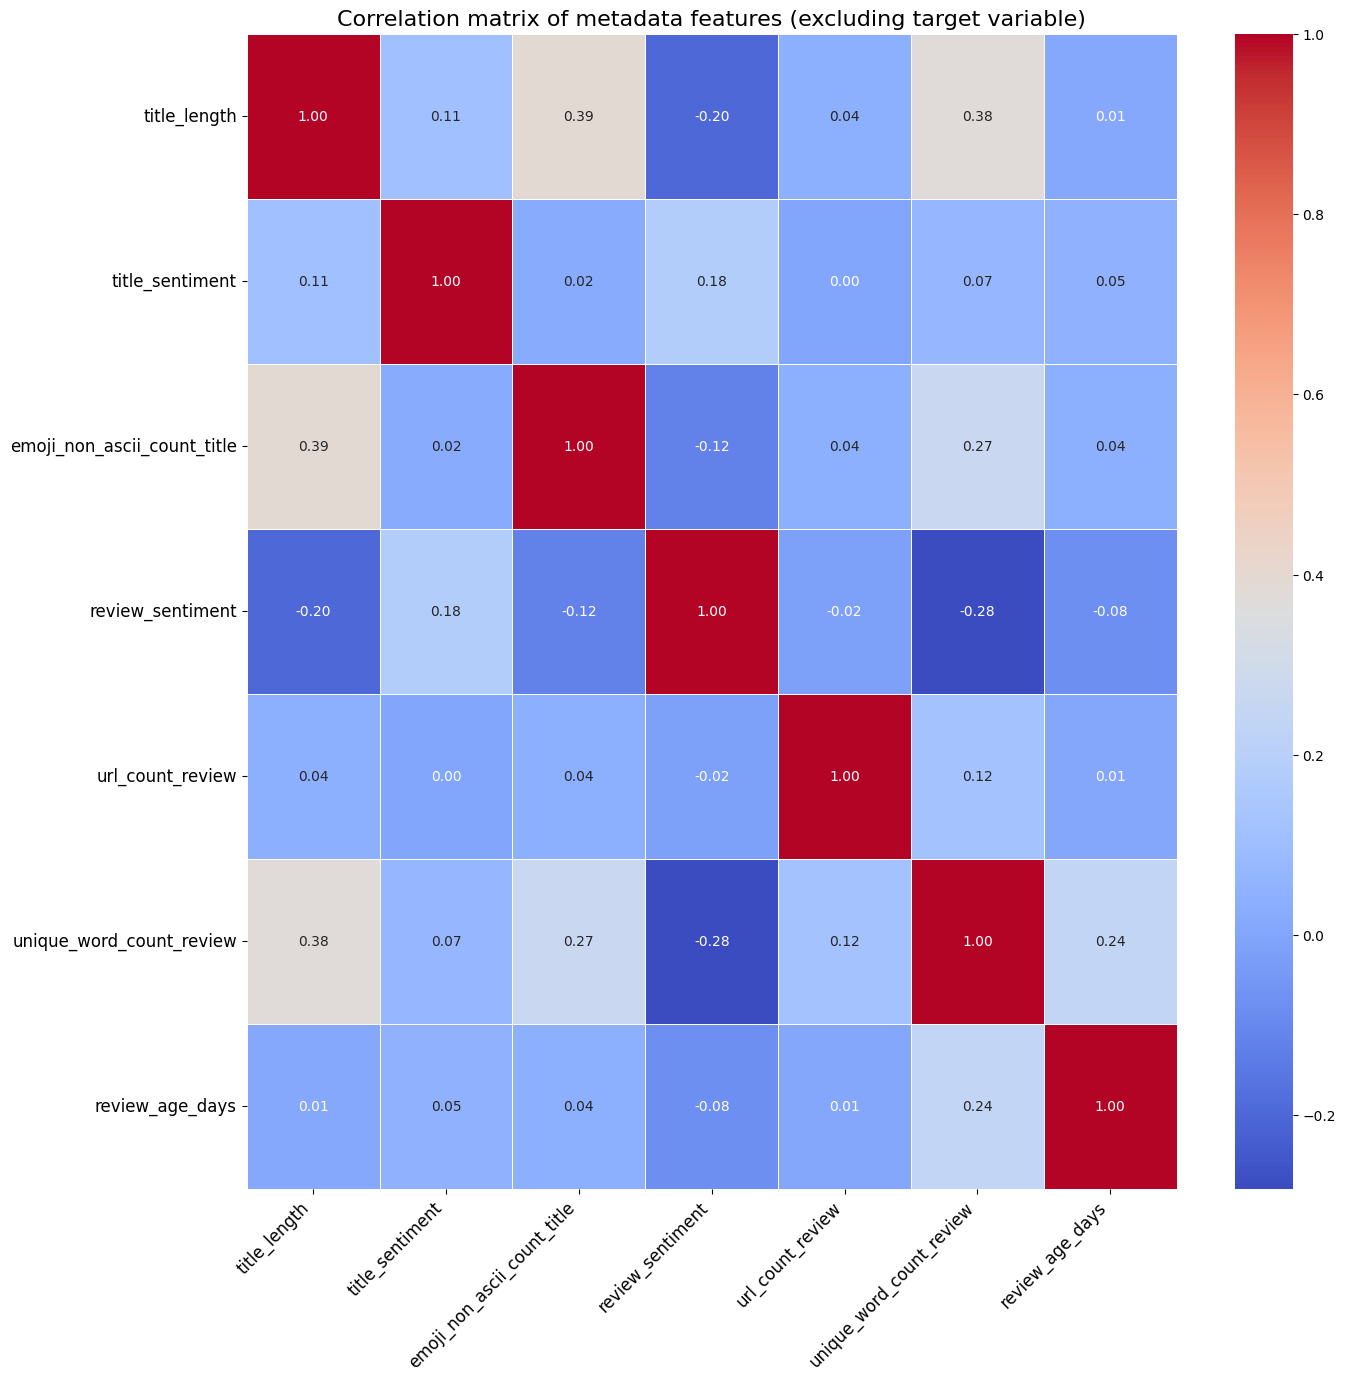

In [ ]:
# Getting only uncorrelated metadata feature columns to check correlation
metadata_features_final = metadata_features_corr_check.copy()
correlation_matrix_final = metadata_features_final.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_final, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotating x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keeping y-axis labels horizontal for better readability
plt.title('Correlation matrix of metadata features (excluding target variable)', fontsize=16)  # Increasing title fontsize
plt.show()

#### After removing highly corelated features above matrix is the final correlation matrix.

In [ ]:
# Creating final modeling dataset

# Defining the columns to be taken in modeling dataset
target_column = 'helpfulness_binary'  # Helpfulness is binary (1 or 0)
# Defining final metadata features after ensuring that no independent metadata features are highly correlated
# List of columns comes from metadata_features_final.columns
final_meta_features = ['title_length', 'title_sentiment', 'emoji_non_ascii_count_title', 'review_sentiment',
                       'url_count_review', 'unique_word_count_review','review_age_days',
                       # including image_available since it was dropped in correlation matrix
                       'image_available']

# Getting only metadata feature columns
modeling_df_meta_final = appliances_df_working_dedup_filter_sample[final_meta_features]

In [ ]:
appliances_df_working_dedup_filter_sample.shape

(49995, 35)

In [ ]:
modeling_df_meta_final.shape

(49995, 8)

In [ ]:
# Creating TFIDF matrix of cleaned review text and storing in a df
# Custom tokenizer function
def custom_tokenizer(text):
    # Splitting text into words using a simple whitespace tokenizer
    words = text.split()
    return words

# Tokenizing text using custom tokenizer
tokenized_text = appliances_df_working_dedup_filter_sample['review_text_clean'].apply(custom_tokenizer).apply(' '.join)

# Creating TF-IDF vectorizer instance with custom tokenizer and top 1000 features
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(tokenized_text)

# Converting TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [ ]:
tfidf_df.shape

(49995, 1000)

In [ ]:
# Combining TF-IDF features with other features

# Restting index on both TFIDF dataframe and metadata feature dataframe
tfidf_df.reset_index(drop=True, inplace=True)
modeling_df_meta_final.reset_index(drop=True, inplace=True)

# Splitting into X and y for modeling
# Concatinating the tfidf_df and Modeling
# X will have the TFIDF df and the final metadata features
X = pd.concat([tfidf_df, modeling_df_meta_final], axis=1)

# y will have the target variable
y = appliances_df_working_dedup_filter_sample[target_column]

In [ ]:
# Checking size - this should be the same as the stratified sample output df size
X.shape

(49995, 1008)

In [ ]:
# Features file
X.to_csv('Appliances_Modeling.csv', index=False)

In [ ]:
# Complete working file
appliances_df_working_dedup_filter_sample.to_csv('Appliances_Modeling_2.csv', index=False)

In [ ]:
# To verify if the file is correctly written
appliances_test_df =pd.read_csv('Appliances_Modeling.csv')
test_df.shape

(49995, 1008)

In [ ]:
# To verify if the file is correctly written
appliances2_test_df =pd.read_csv('Appliances_Modeling_2.csv')
test_df.shape

(49995, 35)

In [ ]:
# Splitting as testing (70%), training (15%) and validation (15%)

# Step 1: Splitting the data into training (70%) and temporary data (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)

# Step 2: Splitting the temporary data into testing (50%) and validation (50%)
X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

# Displaying the shapes of the resulting datasets
## Training ##
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
## Testing ##
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
## Validation ##
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)

X_train shape: (34996, 1008)
y_train shape: (34996,)
X_test shape: (7499, 1008)
y_test shape: (7499,)
X_validation shape: (7500, 1008)
y_validation shape: (7500,)


## Modeling - Supervised ML models to predict helpfulness

In [ ]:
# Libraries required for machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, f1_score, auc
import matplotlib.pyplot as plt
import pickle
import shap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay,confusion_matrix

### Pickling model files to easily save and load

In [ ]:
# Function to save model as pickle file
import pickle

def save_model_pickle(trained_model, pickle_filename):
    """
    Save a trained model to a pickle file.

    Parameters:
        model: Trained machine learning model object.
        filename (str): Name of the pickle file to save the model to.
    """
    with open(pickle_filename, 'wb') as file:
        pickle.dump(trained_model, file)
    print(f"Model saved as {pickle_filename}")

# Example of usage: save_model_pickle(rf_classifier, 'rf_classifier_appliances.pkl')

# Function to load model from pickle file
def load_model_pickle(pickle_filename):
    """
    Load a trained model from a pickle file.

    Parameters:
        filename (str): Name of the pickle file containing the saved model.

    Returns:
        Trained machine learning model object.
    """
    with open(pickle_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f"Model loaded from {pickle_filename}")
    return loaded_model

# Example of usage: rf_classifier_appliances = load_model_pickle('rf_classifier_appliances.pkl')


### Modeling - Random Forest

In [ ]:
# Random Forest Classifier - base model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest base model accuracy:", rf_accuracy)
print("Random Forest base model classification report:")
print(classification_report(y_test, rf_predictions))

Random Forest base model accuracy: 0.9182557674356581
Random Forest base model classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6889
           1       0.36      0.01      0.01       610

    accuracy                           0.92      7499
   macro avg       0.64      0.50      0.49      7499
weighted avg       0.87      0.92      0.88      7499



In [ ]:
# Saving as pickle file
save_model_pickle(rf_classifier, 'rf_base_classifier_appliances.pkl')

Model saved as rf_base_classifier_appliances.pkl


In [ ]:
# Random Forest Classifier - Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=123), param_grid=rf_param_grid, cv=3, scoring='accuracy')
# Hyperparameter tuning on validation dataset
rf_grid_search.fit(X_validation, y_validation)
rf_best_params = rf_grid_search.best_params_
rf_best_model = rf_grid_search.best_estimator_
print("Random Forest Best Parameters:", rf_best_params)

rf_tuned_predictions = rf_grid_search.predict(X_test)

rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_predictions)
print("Random Forest tuned model accuracy:", rf_tuned_accuracy)
print("Random Forest tuned model classification report:")
print(classification_report(y_test, rf_tuned_predictions))

Random Forest Best Parameters: {'max_depth': None, 'n_estimators': 50}
Random Forest tuned model accuracy: 0.9186558207761035
Random Forest tuned model classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6889
           1       0.50      0.01      0.01       610

    accuracy                           0.92      7499
   macro avg       0.71      0.50      0.49      7499
weighted avg       0.89      0.92      0.88      7499



In [ ]:
# Saving as pickle file
save_model_pickle(rf_best_model, 'rf_tuned_classifier_appliances.pkl')

Model saved as rf_tuned_classifier_appliances.pkl


### Modeling - Logistic Regression

In [ ]:
# Logistic Regression - base model
lr_classifier = LogisticRegression(max_iter=1000, random_state=123)
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("Logistic Regression base model accuracy:", lr_accuracy)
print("Logistic Regression base model classification report:")
print(classification_report(y_test, lr_predictions))

Logistic Regression base model accuracy: 0.9167889051873583
Logistic Regression base model classification report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6889
           1       0.43      0.07      0.11       610

    accuracy                           0.92      7499
   macro avg       0.67      0.53      0.53      7499
weighted avg       0.88      0.92      0.89      7499



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# Saving as pickle file
save_model_pickle(lr_classifier, 'lr_base_classifier_appliances.pkl')

Model saved as lr_base_classifier_appliances.pkl


In [ ]:
# Logistic Regression - Hyperparameter Tuning
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 20],
    'penalty': ['l1', 'l2']
}

lr_grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=123),
                              param_grid=lr_param_grid, cv=3, scoring='accuracy')

# Hyperparameter tuning on validation dataset
lr_grid_search.fit(X_validation, y_validation)
lr_best_params = lr_grid_search.best_params_
lr_best_model = lr_grid_search.best_estimator_
print("Logistic Regression Best Parameters:", lr_best_params)

lr_tuned_predictions = lr_grid_search.predict(X_test)

lr_tuned_predictions = lr_grid_search.predict(X_test)
lr_tuned_accuracy = accuracy_score(y_test, lr_tuned_predictions)
print("Logistic Regression tuned model accuracy:", lr_tuned_accuracy)
print("Logistic Regression tuned model classification report:")
print(classification_report(y_test, lr_tuned_predictions))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/

Logistic Regression Best Parameters: {'C': 1, 'penalty': 'l2'}
Logistic Regression tuned model accuracy: 0.9153220429390585
Logistic Regression tuned model classification report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6889
           1       0.38      0.06      0.11       610

    accuracy                           0.92      7499
   macro avg       0.65      0.53      0.53      7499
weighted avg       0.88      0.92      0.89      7499



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# Saving as pickle file
save_model_pickle(lr_best_model, 'lr_tuned_classifier_appliances.pkl')

Model saved as lr_tuned_classifier_appliances.pkl


### Modeling - SVM

In [ ]:
# Support Vector Machine (SVM) - base model
svm_classifier = SVC(kernel='rbf', random_state=123)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM base model accuracy:", svm_accuracy)
print("SVM base model classification report:")
print(classification_report(y_test, svm_predictions))

SVM base model accuracy: 0.9186558207761035
SVM base model classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6889
           1       0.00      0.00      0.00       610

    accuracy                           0.92      7499
   macro avg       0.46      0.50      0.48      7499
weighted avg       0.84      0.92      0.88      7499



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Saving as pickle file
save_model_pickle(svm_classifier, 'svm_base_classifier_appliances.pkl')

Model saved as svm_base_classifier_appliances.pkl


In [ ]:
# Support Vector Machine (SVM) - Hyperparameter Tuning
svm_param_grid = {
    #'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

svm_grid_search = GridSearchCV(SVC(random_state=123), param_grid=svm_param_grid, cv=3, scoring='accuracy')
#svm_grid_search.fit(X_train, y_train)
# Hyperparameter tuning on validation dataset
svm_grid_search.fit(X_validation, y_validation)
svm_best_params = svm_grid_search.best_params_
svm_best_model = svm_grid_search.best_estimator_

print("SVM Best Parameters:", svm_best_params)

svm_tuned_predictions = svm_grid_search.predict(X_test)

svm_tuned_predictions = svm_grid_search.predict(X_test)
svm_tuned_accuracy = accuracy_score(y_test, svm_tuned_predictions)
print("SVM tuned model accuracy:", svm_tuned_accuracy)
print("SVM tuned model classification report:")
print(classification_report(y_test, svm_tuned_predictions))

SVM Best Parameters: {'kernel': 'rbf'}
SVM tuned model accuracy: 0.9186558207761035
SVM tuned model classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6889
           1       0.00      0.00      0.00       610

    accuracy                           0.92      7499
   macro avg       0.46      0.50      0.48      7499
weighted avg       0.84      0.92      0.88      7499



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Saving as pickle file
save_model_pickle(svm_best_model, 'svm_tuned_classifier_appliances.pkl')

Model saved as svm_tuned_classifier_appliances.pkl


### Modeling - XGBoost

In [ ]:
# XGBoost - base model
xgb_classifier = xgb.XGBClassifier(random_state=123)
xgb_classifier.fit(X_train, y_train)
xgb_predictions = xgb_classifier.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost base model accuracy:", xgb_accuracy)
print("XGBoost base model classification report:")
print(classification_report(y_test, xgb_predictions))

XGBoost base model accuracy: 0.9158554473929857
XGBoost base model classification report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6889
           1       0.40      0.07      0.12       610

    accuracy                           0.92      7499
   macro avg       0.66      0.53      0.54      7499
weighted avg       0.88      0.92      0.89      7499



In [ ]:
# Saving as pickle file
save_model_pickle(xgb_classifier, 'xgb_base_classifier_appliances.pkl')

Model saved as xgb_base_classifier_appliances.pkl


In [ ]:
# XGBoost - Hyperparameter Tuning
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xgb_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=123), param_grid=xgb_param_grid, cv=3, scoring='accuracy')

# Hyperparameter tuning on validation dataset
xgb_grid_search.fit(X_validation, y_validation)
xgb_best_params = xgb_grid_search.best_params_
xgb_best_model = xgb_grid_search.best_estimator_

print("XGBoost Best Parameters:", xgb_best_params)

xgb_tuned_predictions = xgb_best_model.predict(X_test)

xgb_tuned_predictions = xgb_grid_search.predict(X_test)
xgb_tuned_accuracy = accuracy_score(y_test, xgb_tuned_predictions)
print("XGBoost tuned model accuracy:", xgb_tuned_accuracy)
print("XGBoost tuned model classification report:")
print(classification_report(y_test, xgb_tuned_predictions))

XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGBoost tuned model accuracy: 0.9174556607547673
XGBoost tuned model classification report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6889
           1       0.44      0.05      0.10       610

    accuracy                           0.92      7499
   macro avg       0.68      0.52      0.53      7499
weighted avg       0.88      0.92      0.89      7499



In [ ]:
# Saving as pickle file
save_model_pickle(xgb_best_model, 'xgb_tuned_classifier_appliances.pkl')

Model saved as xgb_tuned_classifier_appliances.pkl


### Model comparison and feature importance

Random Forest Confusion Matrix:
[[6885    4]
 [ 606    4]]
Random Forest F1-Score: 0.012944983818770227
Random Forest AUC: 0.5029883706264917
Random Forest Accuracy: 0.9186558207761035
Random Forest Precision: 0.5
Random Forest Recall: 0.006557377049180328

Logistic Regression Confusion Matrix:
[[6825   64]
 [ 571   39]]
Logistic Regression F1-Score: 0.1093969144460028
Logistic Regression AUC: 0.5273221267451795
Logistic Regression Accuracy: 0.9153220429390585
Logistic Regression Precision: 0.3786407766990291
Logistic Regression Recall: 0.06393442622950819

SVM Confusion Matrix:
[[6889    0]
 [ 610    0]]
SVM F1-Score: 0.0
SVM AUC: 0.5
SVM Accuracy: 0.9186558207761035
SVM Precision: 1.0
SVM Recall: 0.0

XGBoost Confusion Matrix:
[[6847   42]
 [ 577   33]]
XGBoost F1-Score: 0.09635036496350365
XGBoost AUC: 0.5240008423978354
XGBoost Accuracy: 0.9174556607547673
XGBoost Precision: 0.44
XGBoost Recall: 0.054098360655737705



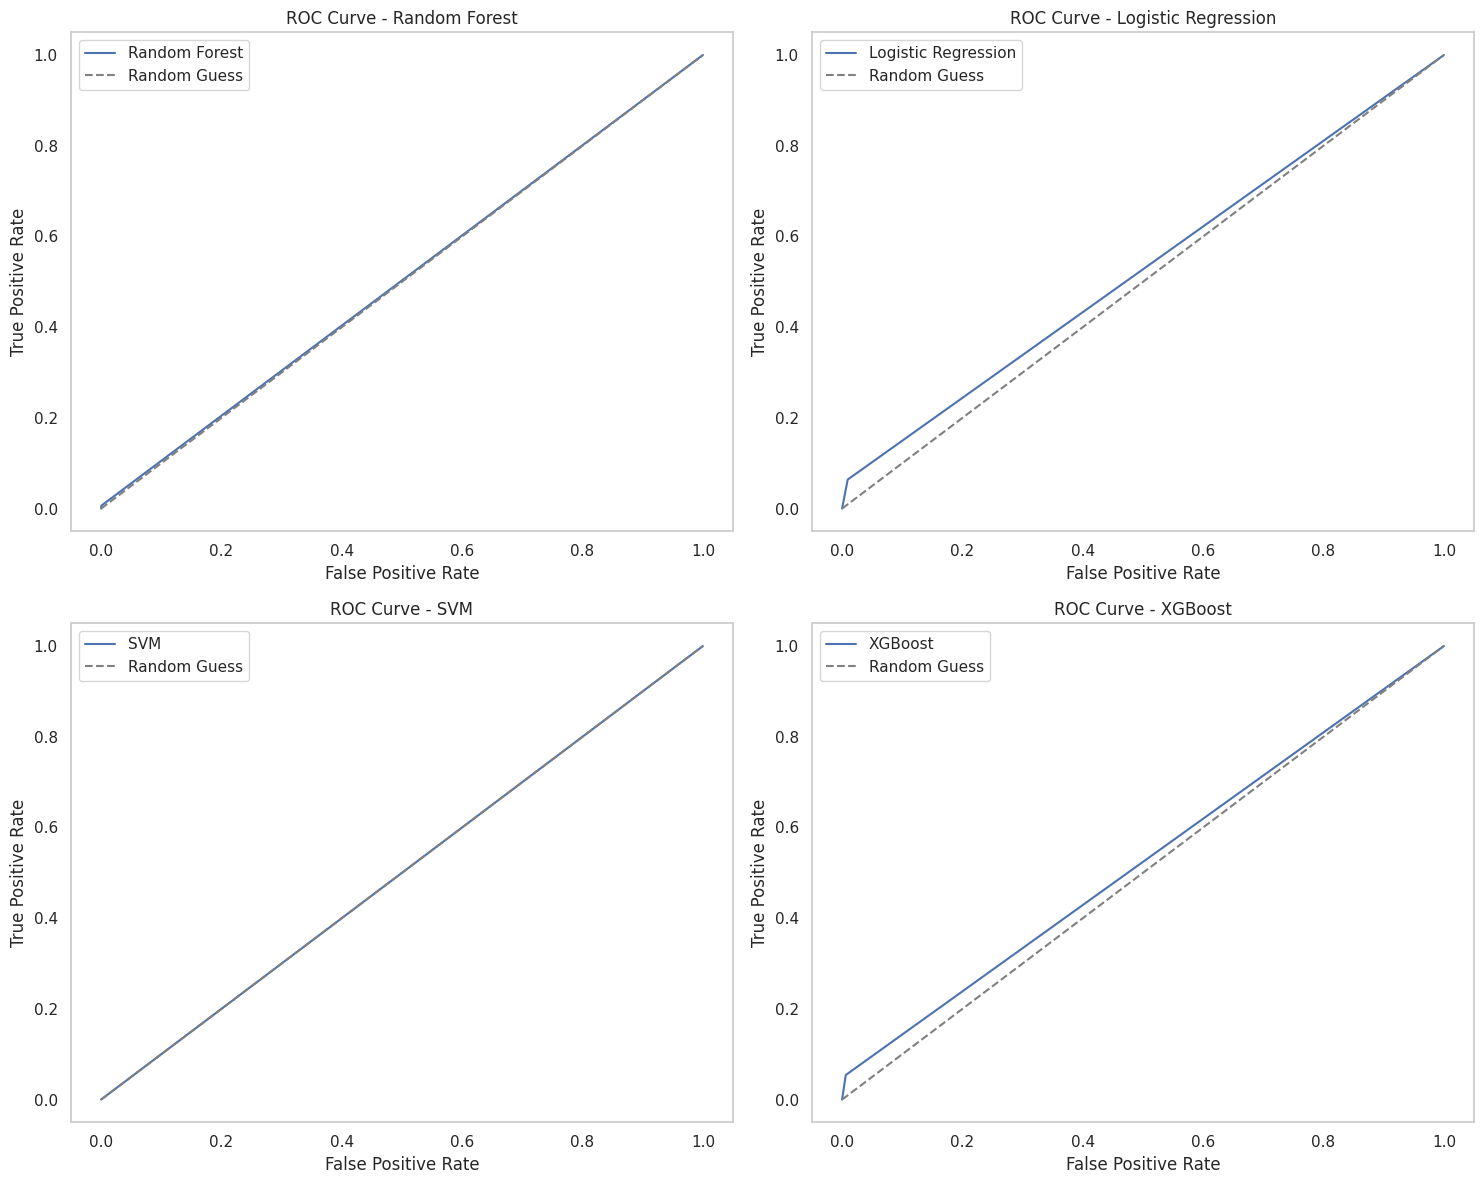

Random Forest Confusion Matrix:
[[6882    7]
 [ 606    4]]
Random Forest F1-Score: 0.01288244766505636
Random Forest AUC: 0.5027706322029178
Random Forest Accuracy: 0.9182557674356581
Random Forest Precision: 0.36363636363636365
Random Forest Recall: 0.006557377049180328

Logistic Regression Confusion Matrix:
[[6835   54]
 [ 570   40]]
Logistic Regression F1-Score: 0.11363636363636363
Logistic Regression AUC: 0.528867593621573
Logistic Regression Accuracy: 0.9167889051873583
Logistic Regression Precision: 0.425531914893617
Logistic Regression Recall: 0.06557377049180328

SVM Confusion Matrix:
[[6889    0]
 [ 610    0]]
SVM F1-Score: 0.0
SVM AUC: 0.5
SVM Accuracy: 0.9186558207761035
SVM Precision: 1.0
SVM Recall: 0.0

XGBoost Confusion Matrix:
[[6824   65]
 [ 566   44]]
XGBoost F1-Score: 0.12239221140472879
XGBoost AUC: 0.5313479079263925
XGBoost Accuracy: 0.9158554473929857
XGBoost Precision: 0.4036697247706422
XGBoost Recall: 0.07213114754098361



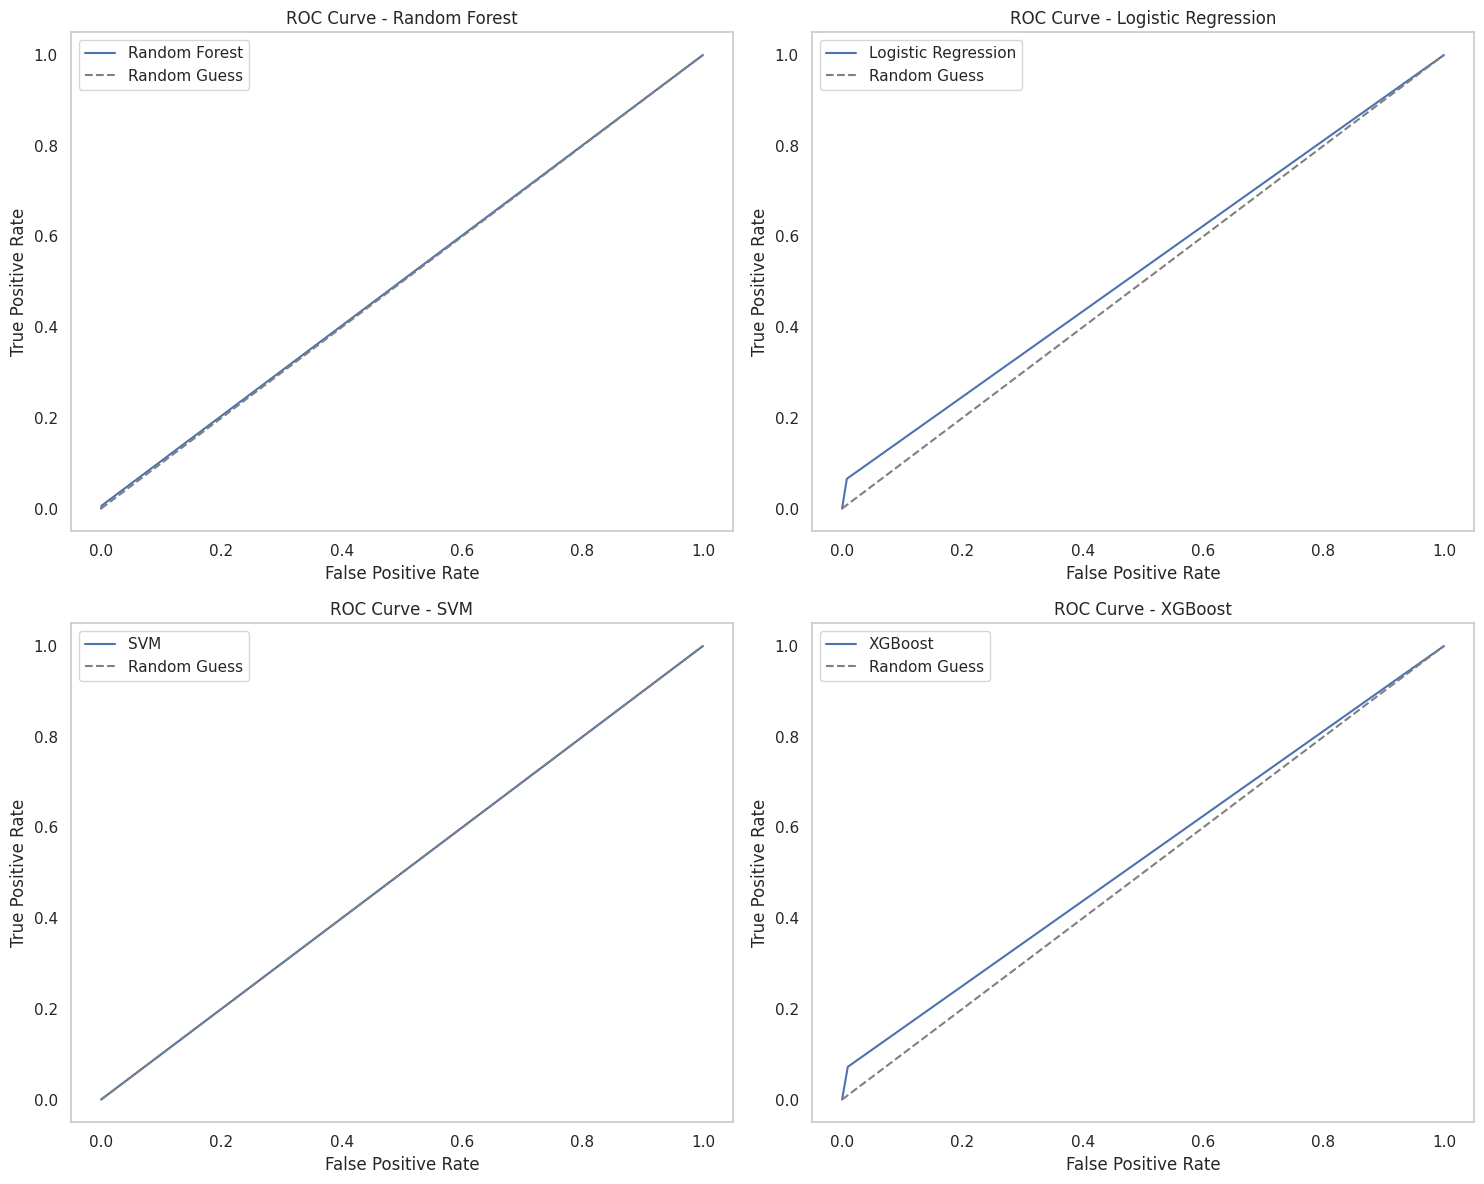

In [ ]:
from sklearn.metrics import precision_score, recall_score
# Function to plot ROC curve
def plot_roc_curve(ax, fpr, tpr, model_name):
    ax.plot(fpr, tpr, label=model_name)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend()
    ax.grid(True)

# Function to evaluate and compare models
def evaluate_models(models, X_test, y_test):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

    for model_name, model in models.items():
        ax = axes.flatten()[list(models.keys()).index(model_name)]

        # Predictions
        y_pred = model.predict(X_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"{model_name} Confusion Matrix:")
        print(cm)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plot_roc_curve(ax, fpr, tpr, model_name)

        # F1-Score
        f1 = f1_score(y_test, y_pred)
        print(f"{model_name} F1-Score: {f1}")

        # Area under ROC curve
        roc_auc = auc(fpr, tpr)
        print(f"{model_name} AUC: {roc_auc}")

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{model_name} Accuracy: {accuracy}")

        # Precision
        precision = precision_score(y_test, y_pred, zero_division=1)
        print(f"{model_name} Precision: {precision}")

        # Recall
        recall = recall_score(y_test, y_pred)
        print(f"{model_name} Recall: {recall}")

        print()

    plt.tight_layout()
    plt.show()

# Defining the models to compare
tuned_models = {
    "Random Forest": rf_best_model,
    "Logistic Regression": lr_best_model,
    "SVM": svm_best_model,
    "XGBoost": xgb_best_model
}


base_models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": lr_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier
}


# Evaluation and comparison of models
evaluate_models(tuned_models, X_test, y_test)
evaluate_models(base_models, X_test, y_test)

In [ ]:
# Consolidating all evaluation metrics results in 1 dataframe
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to generate evaluation results
def generate_evaluation_results(models, X_test, y_test):
    results = []

    for model_name, model in models.items():
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc
        })

    return pd.DataFrame(results)

# Defining the base models to compare
base_models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": lr_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier
}

# Defining the tuned models to compare
tuned_models = {
    "Random Forest (Tuned)": rf_best_model,
    "Logistic Regression (Tuned)": lr_best_model,
    "SVM (Tuned)": svm_best_model,
    "XGBoost (Tuned)": xgb_best_model
}

# Generating evaluation results for base models
base_evaluation_results = generate_evaluation_results(base_models, X_test, y_test)

# Generating evaluation results for tuned models
tuned_evaluation_results = generate_evaluation_results(tuned_models, X_test, y_test)

# Combining the results of base and tuned models
consolidated_evaluation_results = pd.concat([base_evaluation_results, tuned_evaluation_results], ignore_index=True)

consolidated_evaluation_results

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,0.918256,0.363636,0.006557,0.012882,0.502771
1,Logistic Regression,0.916789,0.425532,0.065574,0.113636,0.528868
2,SVM,0.918656,0.000000,0.000000,0.000000,0.500000
3,XGBoost,0.915855,0.403670,0.072131,0.122392,0.531348
4,Random Forest (Tuned),0.918656,0.500000,0.006557,0.012945,0.502988
5,Logistic Regression (Tuned),0.915322,0.378641,0.063934,0.109397,0.527322
6,SVM (Tuned),0.918656,0.000000,0.000000,0.000000,0.500000
7,XGBoost (Tuned),0.917456,0.440000,0.054098,0.096350,0.524001


Logistic Regression Confusion Matrix:
[[6835   54]
 [ 570   40]]


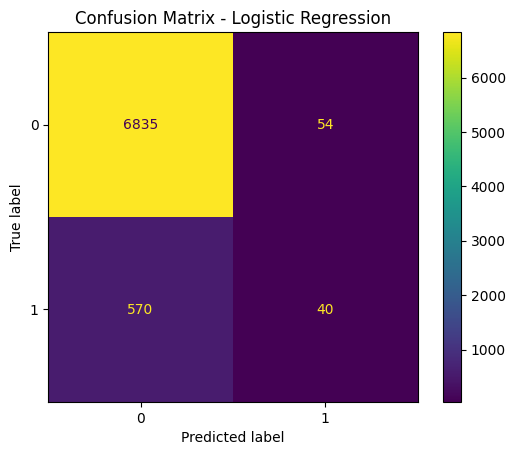

SVM Confusion Matrix:
[[6889    0]
 [ 610    0]]


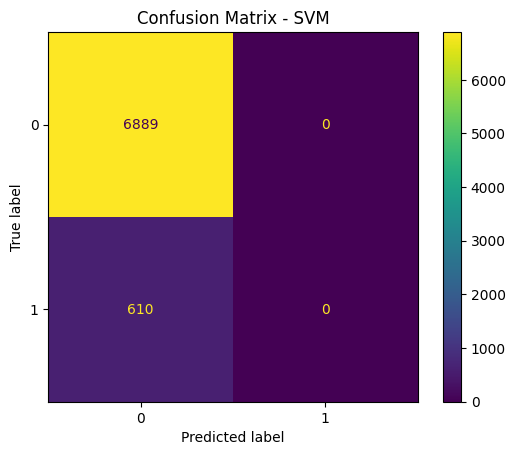

Random Forest Confusion Matrix:
[[6882    7]
 [ 606    4]]


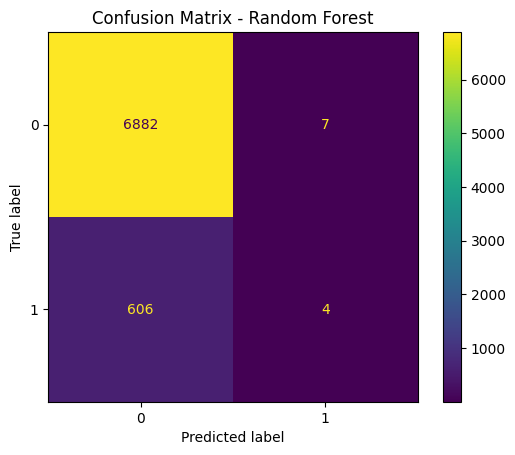

XGBoost Confusion Matrix:
[[6824   65]
 [ 566   44]]


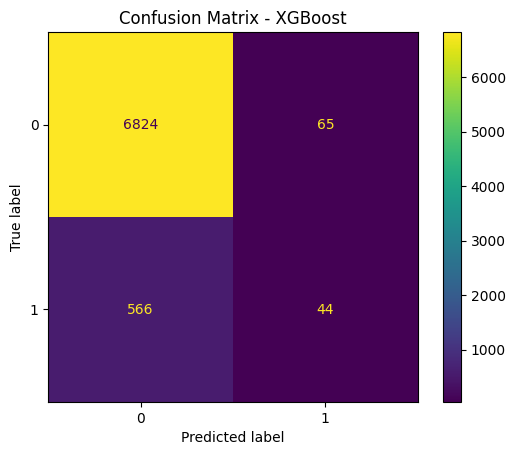

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Logistic Regression
y_pred_lr = lr_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

# SVM
y_pred_svm = svm_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svm, "SVM")

# Random Forest
y_pred_test = rf_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred_test, "Random Forest")

# XGBoost
y_pred_xgb = xgb_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")

Logistic Regression Tuned Confusion Matrix:
[[6825   64]
 [ 571   39]]


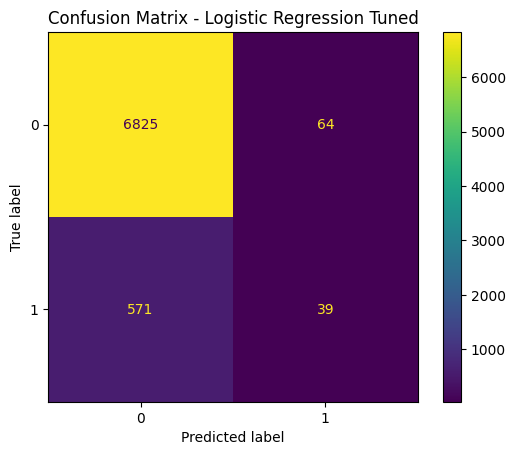

SVM Tuned Confusion Matrix:
[[6889    0]
 [ 610    0]]


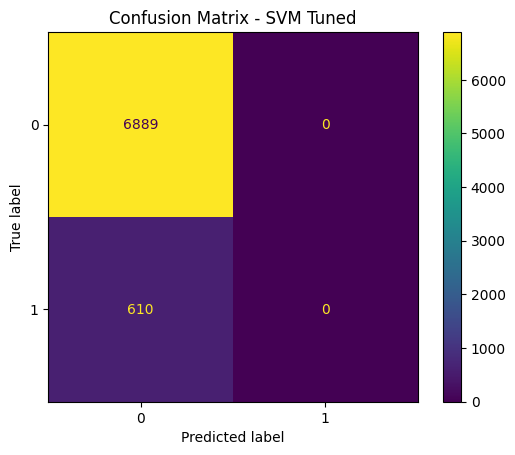

Random Forest Tuned Confusion Matrix:
[[6885    4]
 [ 606    4]]


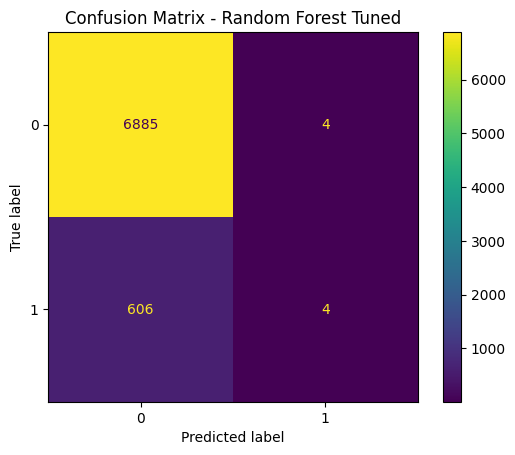

XGBoost Tuned Confusion Matrix:
[[6847   42]
 [ 577   33]]


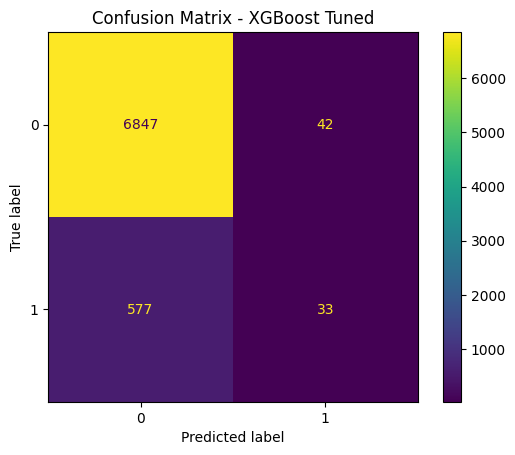

In [ ]:
# Confusion matrix for tuned models

# Logistic Regression
y_pred_lr = lr_best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression Tuned")

# SVM
y_pred_svm = svm_best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svm, "SVM Tuned")

# Random Forest
y_pred_test = rf_best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_test, "Random Forest Tuned")

# XGBoost
y_pred_xgb = xgb_best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Tuned")

In [ ]:
consolidated_evaluation_results

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,0.918256,0.363636,0.006557,0.012882,0.502771
1,Logistic Regression,0.916789,0.425532,0.065574,0.113636,0.528868
2,SVM,0.918656,0.000000,0.000000,0.000000,0.500000
3,XGBoost,0.915855,0.403670,0.072131,0.122392,0.531348
4,Random Forest (Tuned),0.918656,0.500000,0.006557,0.012945,0.502988
5,Logistic Regression (Tuned),0.915322,0.378641,0.063934,0.109397,0.527322
6,SVM (Tuned),0.918656,0.000000,0.000000,0.000000,0.500000
7,XGBoost (Tuned),0.917456,0.440000,0.054098,0.096350,0.524001


In [ ]:
# Function to plot feature importance (top 20 as default)
def plot_top_n_feature_importance(importance, names, model_name, top_n=20):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    top_features = feature_importance.head(top_n)
    plt.figure(figsize=(20, 12))
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.show()

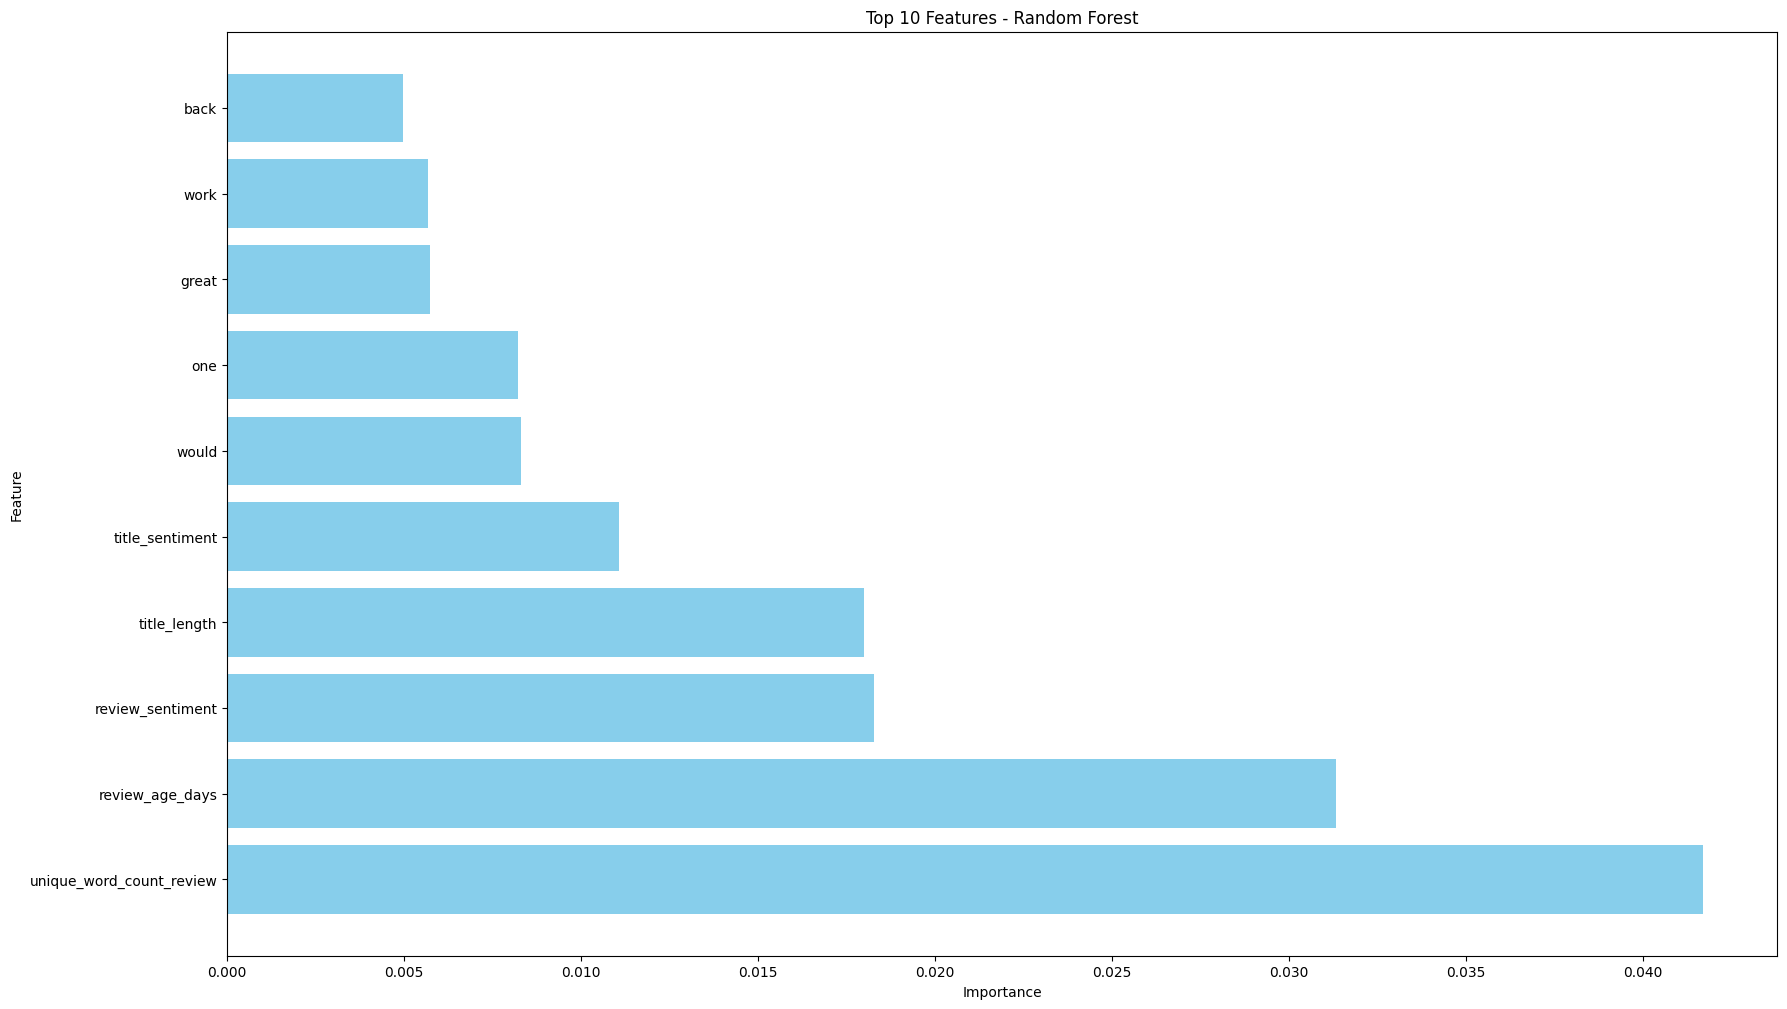

In [ ]:
# Random Forest Feature Importance
#rf_feature_importance = rf_best_model.feature_importances_
rf_feature_importance = rf_classifier.feature_importances_
plot_top_n_feature_importance(rf_feature_importance, X_train.columns, 'Random Forest', 10)

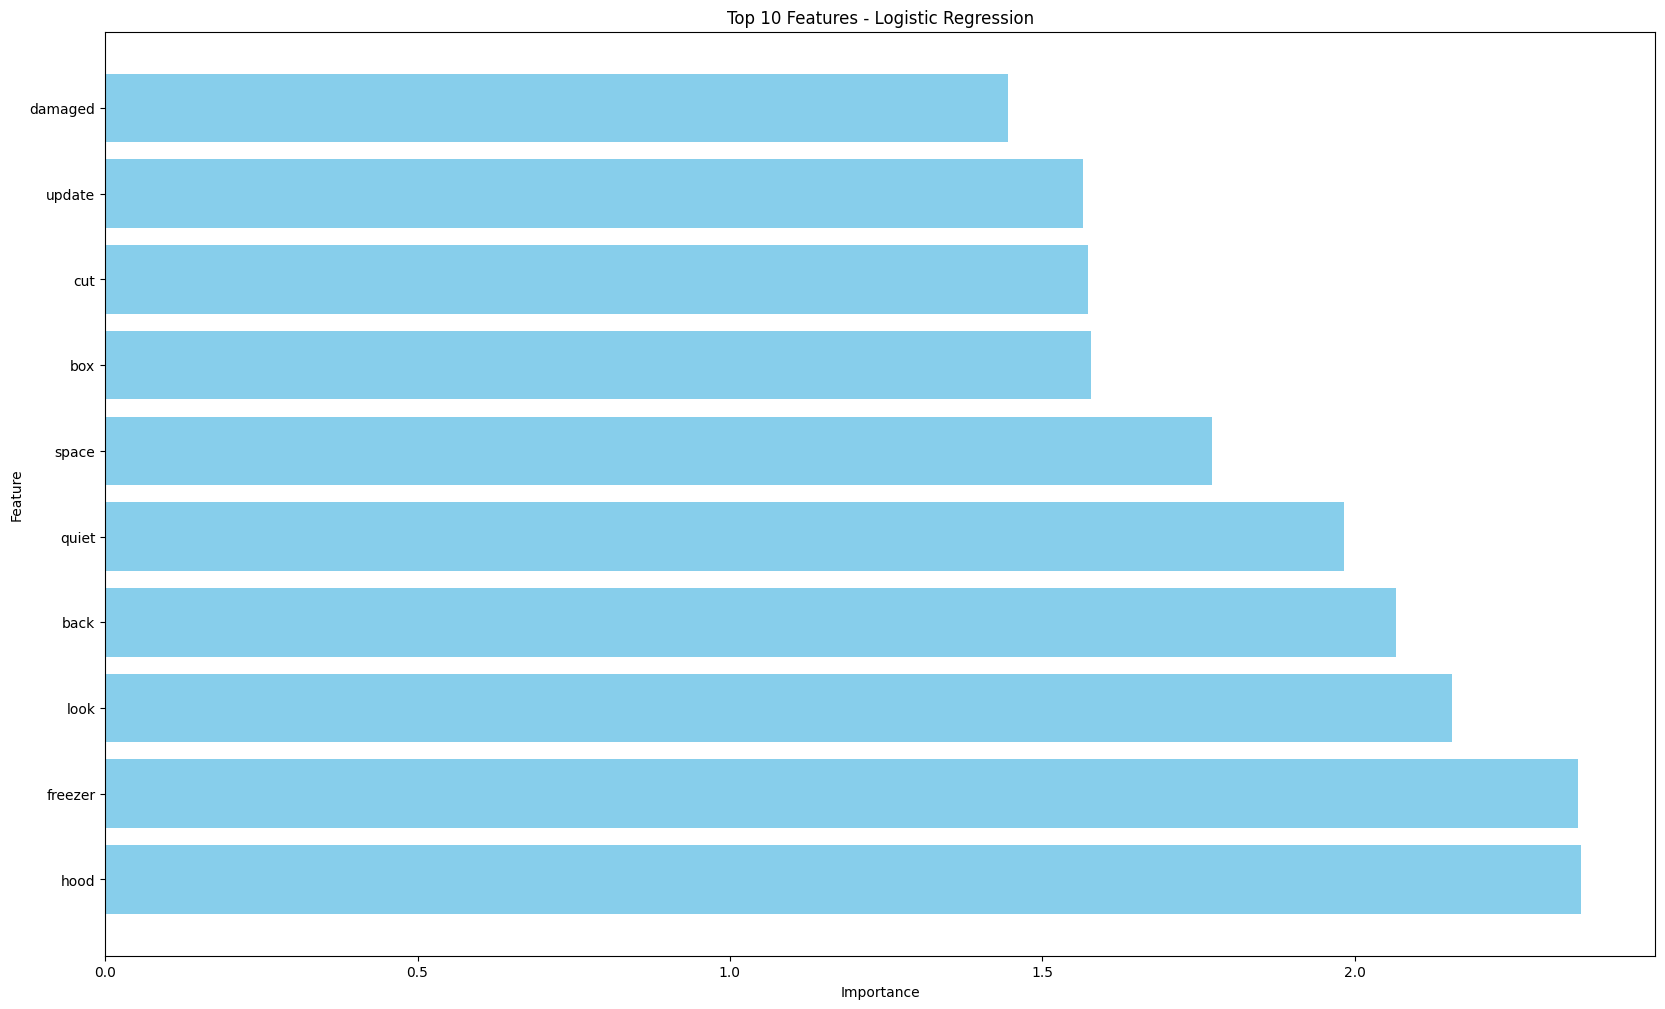

In [ ]:
# Logistic Regression Coefficients (for positive and negative impact)
#lr_feature_importance = lr_best_model.coef_[0]
lr_feature_importance = lr_classifier.coef_[0]
plot_top_n_feature_importance(lr_feature_importance, X_train.columns, 'Logistic Regression', 10)

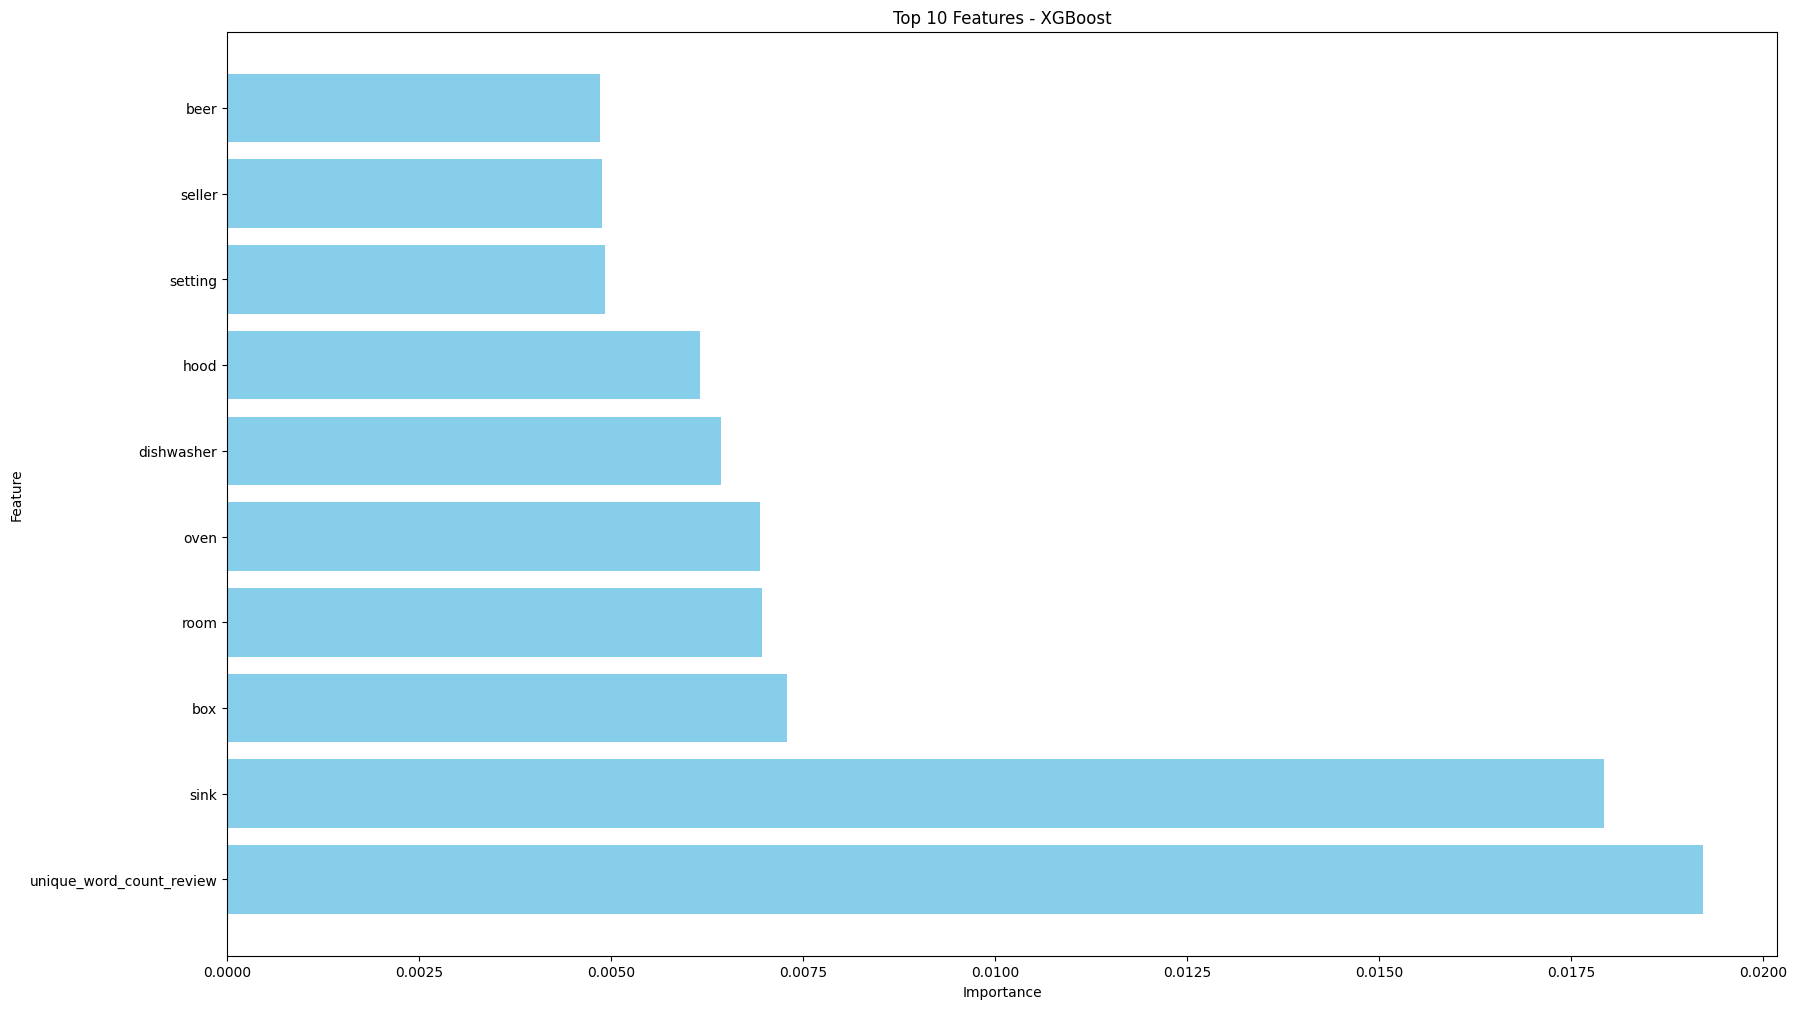

In [ ]:
# XGBoost Feature Importance
#xgb_feature_importance = xgb_best_model.feature_importances_
xgb_feature_importance = xgb_classifier.feature_importances_
plot_top_n_feature_importance(xgb_feature_importance, X_train.columns, 'XGBoost', 10)

In [ ]:
X_train.columns

Index(['able', 'absolutely', 'accurate', 'actual', 'actually', 'adapter',
       'add', 'added', 'additional', 'advertised',
       ...
       'youtube', 'yr', 'title_length', 'title_sentiment',
       'emoji_non_ascii_count_title', 'review_sentiment', 'url_count_review',
       'unique_word_count_review', 'review_age_days', 'image_available'],
      dtype='object', length=1008)

### Model explainability and drivers of helpfulness

In [ ]:

def plot_imp_feature_distribution_hist(df, feature_name, target_column):
    sns.set(style="whitegrid", rc={"grid.linewidth": 0})  # rc parameter to be tweaked to get gridlines
    plt.figure(figsize=(8, 6))

    # Plotting histogram for non-helpful cases
    sns.histplot(data=df[df[target_column] == 0], x=feature_name, color='skyblue', label='Not Helpful', kde=True)

    # Plotting histogram for helpful cases
    sns.histplot(data=df[df[target_column] == 1], x=feature_name, color='salmon', label='Helpful', kde=True)

    plt.title(f'Distribution of {feature_name} across Helpfulness Levels')
    plt.xlabel(feature_name)
    plt.ylabel('Count')

    plt.legend()

    plt.show()

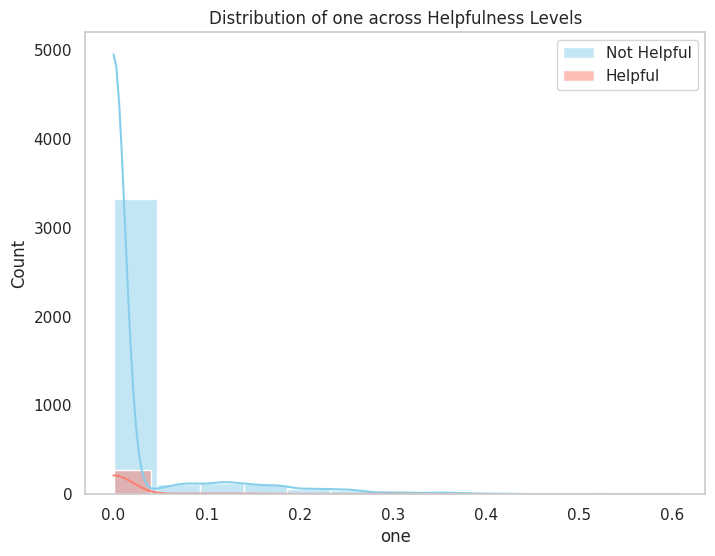

In [ ]:
# Specifying the (important) feature that needs to be explored across helpfulness values
feature_to_explore = 'one'

# Plotting the feature distribution across helpfulness
plot_imp_feature_distribution_hist(pd.concat([X, y], axis=1), feature_to_explore, 'helpfulness_binary')

In [ ]:
y

26600     0
491571    0
60322     0
83842     0
489173    0
         ..
423741    1
457031    1
600080    1
457034    1
423738    1
Name: helpfulness_binary, Length: 49995, dtype: int64

#### For tree-based models (Random Forest / XGBoost) - feature importance of review terms

In [ ]:
# Specifying the tree based classifier instance to get the feature importance values
#feature_importances = rf_classifier.feature_importances_
feature_importances = xgb_classifier.feature_importances_

# Obtaining feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Dictionary to map feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sorting the dictionary by importance (descending order)
sorted_feature_importance_desc = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Printing the top N important terms along with their relative importance
top_n = 20
for term, importance in sorted_feature_importance_desc[:top_n]:
    print(f"Review term: {term}, Importance: {importance}")

Review term: sink, Importance: 0.017925698310136795
Review term: box, Importance: 0.007291016168892384
Review term: room, Importance: 0.006966351065784693
Review term: oven, Importance: 0.006938736420124769
Review term: dishwasher, Importance: 0.006436054594814777
Review term: hood, Importance: 0.006155201233923435
Review term: setting, Importance: 0.004918325692415237
Review term: seller, Importance: 0.004876530729234219
Review term: beer, Importance: 0.004849803633987904
Review term: freezer, Importance: 0.004815712105482817
Review term: update, Importance: 0.004646741785109043
Review term: photo, Importance: 0.004522938281297684
Review term: picture, Importance: 0.004270517732948065
Review term: pull, Importance: 0.004233380313962698
Review term: laundromat, Importance: 0.004207697696983814
Review term: apartment, Importance: 0.004203285556286573
Review term: larger, Importance: 0.004196317866444588
Review term: sent, Importance: 0.004183262586593628
Review term: cool, Importance: 0

## Shapley values

In [ ]:
import shap

# Creating explainer objects for each model

# For XGBoost base model
xgb_explainer_base = shap.TreeExplainer(xgb_classifier)
# For XGBoost tuned model
xgb_explainer_tuned = shap.TreeExplainer(xgb_best_model)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [ ]:
# Using the explainer objects to calculate SHAP values for the test dataset

# For XGBoost base model
xgb_shap_base_values = xgb_explainer_base(X_test)

# For XGBoost tuned model
xgb_shap_tuned_values = xgb_explainer_tuned(X_test)

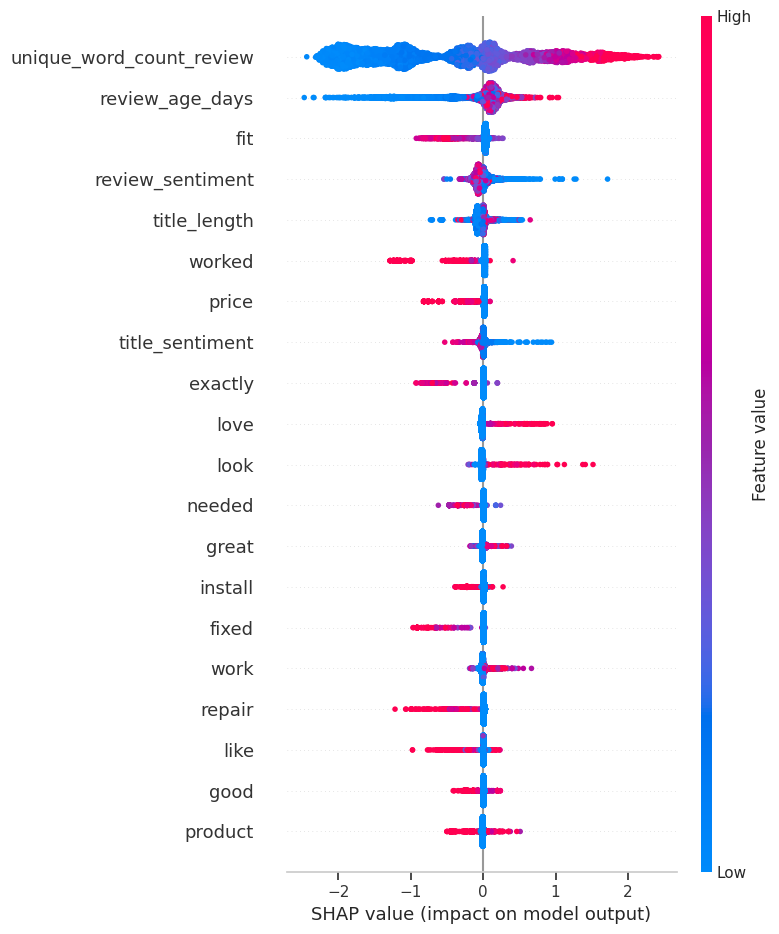

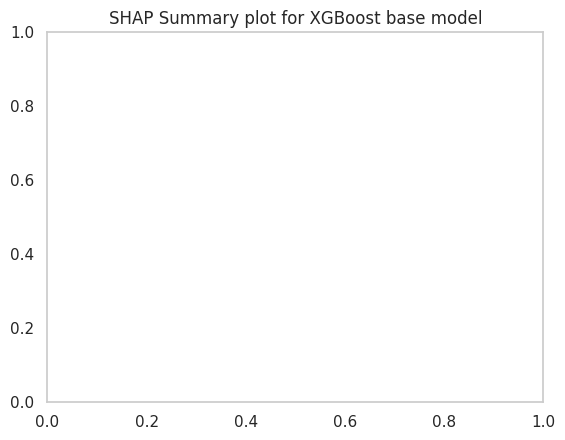

In [ ]:
# summary_plot will generate summary plots for each model, showing the distribution of SHAP values for each feature
# Features are sorted by their importance, with the most important features at the top
# The color of each point indicates the value of the feature (red for high values, blue for low values)
# The position of the point on the x-axis indicates the impact of that feature on the model's output

# Plot for XGBoost base model
shap.summary_plot(xgb_shap_base_values, X_test, feature_names=X_train.columns)
# Adding title to the plot
plt.title('SHAP Summary plot for XGBoost base model')
# Displaying the plot
plt.show()

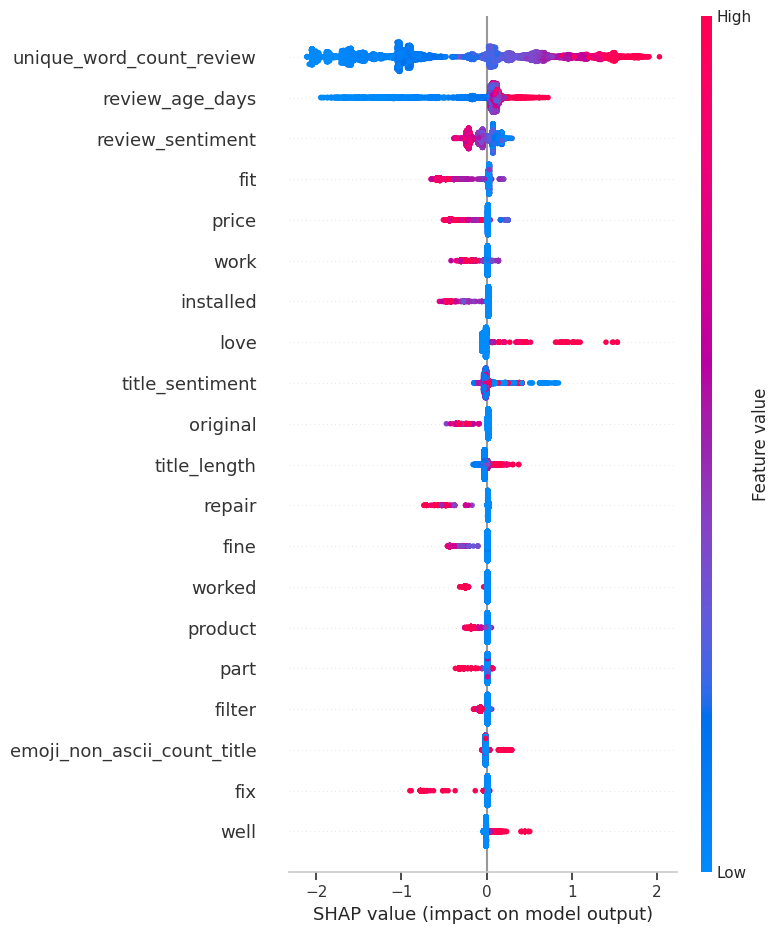

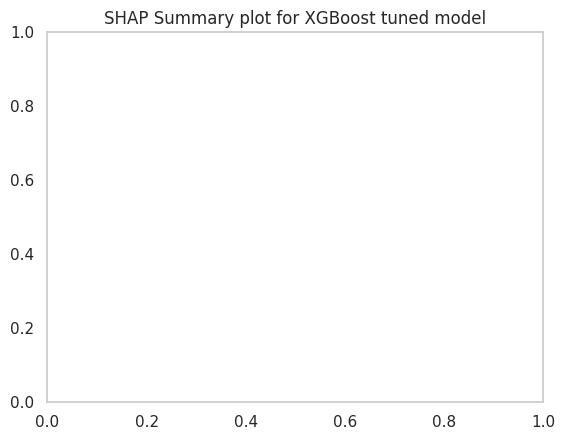

In [ ]:
# summary_plot will generate summary plots for each model, showing the distribution of SHAP values for each feature
# Features are sorted by their importance, with the most important features at the top
# The color of each point indicates the value of the feature (red for high values, blue for low values)
# The position of the point on the x-axis indicates the impact of that feature on the model's output

# Plot for XGBoost tuned model
shap.summary_plot(xgb_shap_tuned_values, X_test, feature_names=X_train.columns)
# Adding title to the plot
plt.title('SHAP Summary plot for XGBoost tuned model')
# Displaying the plot
plt.show()

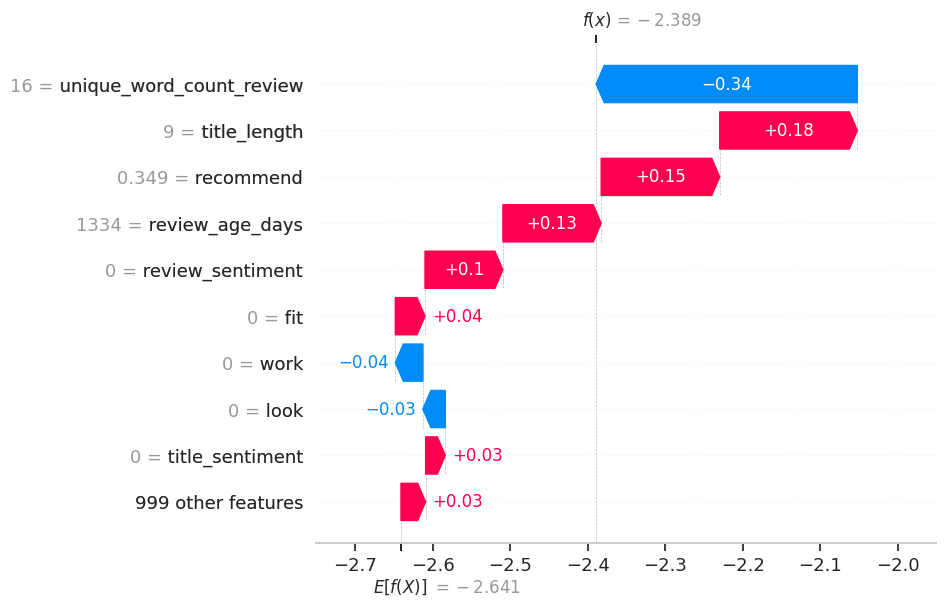

In [ ]:
# Visualizing the first prediction's explanation using a waterfall plot
# The chart shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output
# Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

# XGBoost base model waterfall plot
shap.plots.waterfall(xgb_shap_base_values[0])

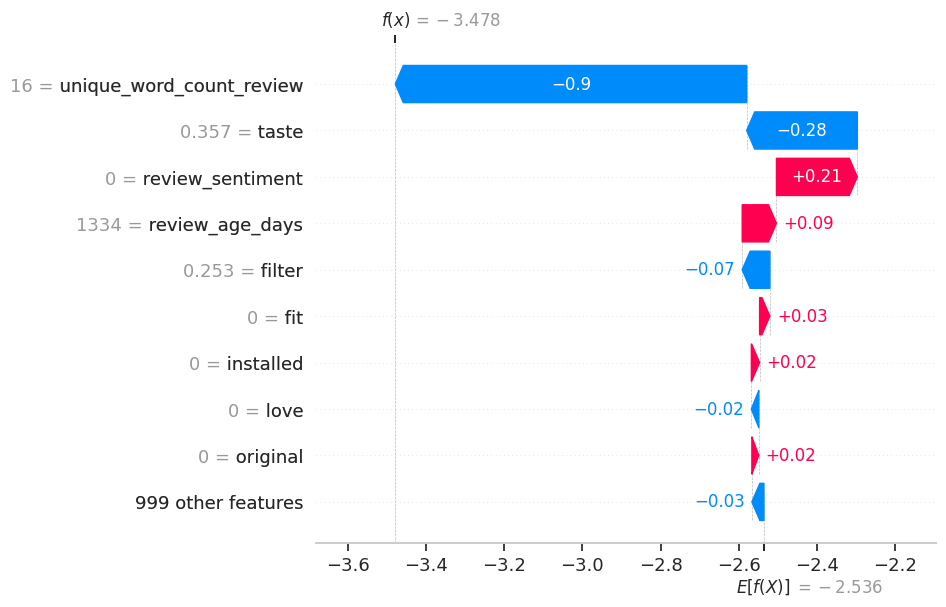

In [ ]:
# Visualizing the first prediction's explanation using a waterfall plot
# The chart shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output
# Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

# XGBoost tuned model waterfall plot
shap.plots.waterfall(xgb_shap_tuned_values[0])

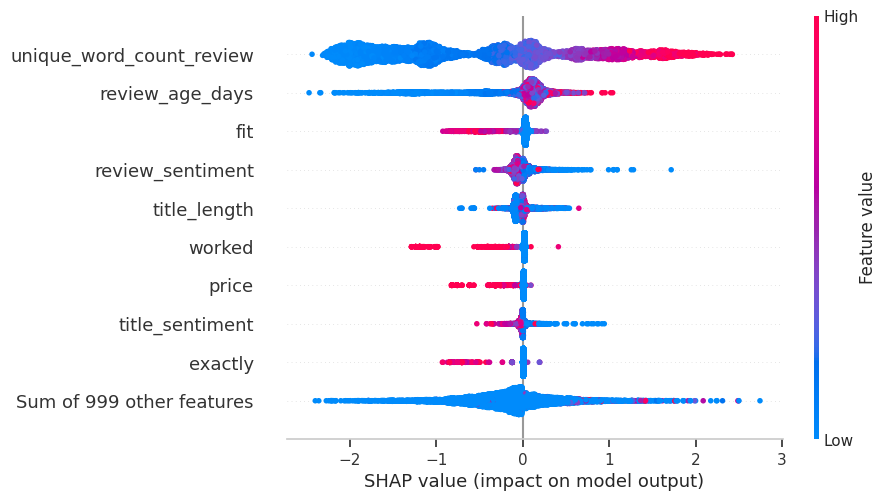

In [ ]:
# Summarizing the effects of all the features
# The plot below sorts features by the sum of SHAP value magnitudes over all samples
# It uses SHAP values to show the distribution of the impacts each feature has on the model output
# The color represents the feature value (red high, blue low)
# Greater concentration of red for a feature will indicate that the feature positively affects helpfulness

# XGBoost base model beeswarm plot
shap.plots.beeswarm(xgb_shap_base_values)

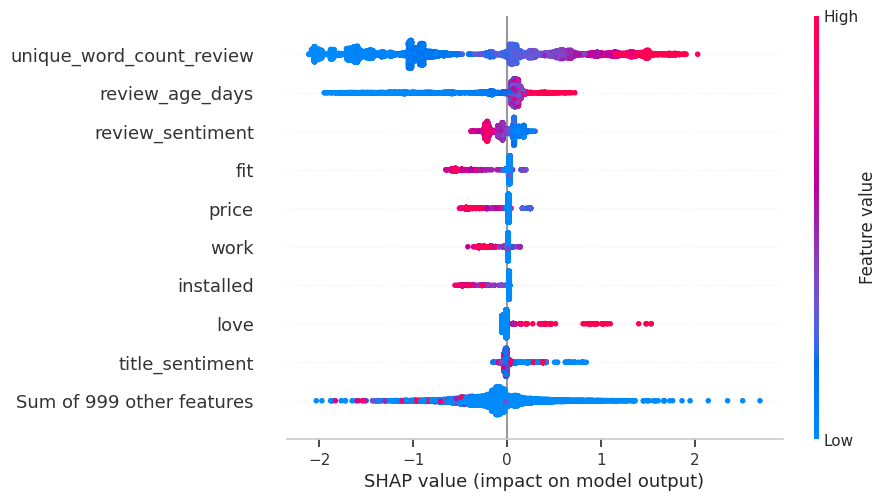

In [ ]:
# Summarizing the effects of all the features
# The plot below sorts features by the sum of SHAP value magnitudes over all samples
# It uses SHAP values to show the distribution of the impacts each feature has on the model output
# The color represents the feature value (red high, blue low)
# Greater concentration of red for a feature will indicate that the feature positively affects helpfulness

# XGBoost tuned model beeswarm plot
shap.plots.beeswarm(xgb_shap_tuned_values)